<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching_test_case_weather_multi_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from alphaRNN import *
from keras.layers import Layer
from keras import backend as K
from keras import layers
import keras.layers
#from alphaRNN import *
from keras import *
from keras.legacy import interfaces

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Please see MFD: comments and "to do" comments

# Generate switching data set

In [0]:
p = 30 # the number of lags (in both the data and the models)
#vols=generate_vol_sample(1000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

#vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [0]:
uni_data = df[['p (mbar)', 'T (degC)', 'rho (g/m**3)']] #['T (degC)']
uni_date = df['Date Time']
uni_data.index = uni_date
uni_data.head()
#uni_data = uni_data.values
#uni_train_mean = uni_data[:split].mean()
#uni_train_std = uni_data[:split].std()
#uni_data = (uni_data - uni_data_mean)/uni_train_std
#print(uni_data)
#df = pd.DataFrame(vols, columns=['vol'])

#plt.plot(uni_date,uni_data)






,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


In [0]:
#df = pd.DataFrame(vols, columns=['vol'])

# prepare data for RNNs

In [0]:
#features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
use_features = ['p (mbar)', 'T (degC)', 'rho (g/m**3)'] 
target = 'T (degC)'

n_steps = 20 # number of lags to include in the model

train_weight = 0.8
#split = int(len(df)*train_weight)
#uni_train_mean = uni_data[:split].mean()
#uni_train_std = uni_data[:split].std()
#uni_data = (uni_data - uni_train_mean)/uni_train_std
#print(uni_data)

df_new = df[:30000]
df_new[use_features].astype('float32').dtypes
#print(df_new[use_features])
split = int(len(df_new)*train_weight)
print(split)
df_train = df_new[use_features].iloc[:split] 
df_train[use_features].astype('float32').dtypes
mu = df_train[use_features].mean()
sigma = df_train[use_features].std()
std_df_train = (df_train[use_features] - mu)/sigma
#.apply(lambda x: (x - mu) / sigma)
#print(std_df_train)
df_train = std_df_train 
#print(df_train[use_features])
#df_new = df[split:10000]
df_test = df[use_features].loc[split:]
#print(df_test)
std_df_test = (df_test[use_features].loc[split:30000] - mu)/sigma

#.apply(lambda x: (x-mu)/sigma).iloc[split:30000]
print("second df")
df_test = std_df_test
#print(df_test[use_features].loc[split])
print(std_df_test)
print("mu" + str(mu))
print("sigma" + str(sigma))


#train_weight = 0.8
#split = int(len(df)*train_weight)

#uni_train_mean = uni_data[:split].mean()
#uni_train_std = uni_data[:split].std()
#uni_data = (uni_data - uni_train_mean)/uni_train_std
#print(uni_data)

#df_train = df[use_features].iloc[:split]
#print(df_train)
#df_test = df[use_features].iloc[split:]

24000
second df
       p (mbar)  T (degC)  rho (g/m**3)
24000  0.659015  1.258497     -0.949387
24001  0.656990  1.247276     -0.942176
24002  0.658002  1.234809     -0.933474
24003  0.666099  1.211120     -0.913832
24004  0.668124  1.184938     -0.892201
24005  0.663063  1.135068     -0.844462
24006  0.662051  1.132574     -0.843219
24007  0.672172  1.158756     -0.866342
24008  0.681281  1.213614     -0.909854
24009  0.687354  1.233562     -0.923280
24010  0.701524  1.213614     -0.893444
24011  0.716705  1.167483     -0.852916
24012  0.739984  1.130080     -0.818604
24013  0.759215  1.087690     -0.778076
24014  0.788566  1.056521     -0.743765
24015  0.795651  1.009144     -0.700253
24016  0.795651  0.946806     -0.646796
24017  0.793627  0.876987     -0.588367
24018  0.802736  0.819636     -0.538142
24019  0.818930  0.788467     -0.506317
24020  0.820954  0.761038     -0.481702
24021  0.843221  0.775999     -0.486675
24022  0.852330  0.772259     -0.482448
24023  0.860427  0.72986

In [0]:
#def get_lagged_features(value, n_steps):
#    lag_list = []
#    for lag in range(n_steps, 0, -1):
#        lag_list.append(value.shift(lag))
#    return pd.concat(lag_list, axis=1)

In [0]:
def get_lagged_features(value, n_steps,n_steps_ahead):
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
n_steps_ahead=10

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(23971, 20, 3) (23971, 1, 1) (5971, 20, 3) (5971, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

time_size = y_train_reg.shape[1]


In [0]:
print(train_batch_size)

23971


# Define Alpha RNN models

In [0]:
tf.get_collection('alpha_t')

[]

In [0]:
class AlphaRNNCell(Layer):
    """Cell class for AlphaRNN.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
    """

    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 **kwargs):
        super(AlphaRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        self.alpha = self.add_weight(shape=(1,),
                                        name='alpha',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        self.built = True

    def call(self, inputs, states, training=None):
        prev_output = states[0]
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(prev_output),
                self.recurrent_dropout,
                training=training)

        dp_mask = self._dropout_mask
        rec_dp_mask = self._recurrent_dropout_mask

        if dp_mask is not None:
            h = K.dot(inputs * dp_mask, self.kernel)
        else:
            h = K.dot(inputs, self.kernel)
        if self.bias is not None:
            h = K.bias_add(h, self.bias)

        if rec_dp_mask is not None:
            prev_output *= rec_dp_mask
        output = h + K.dot(prev_output, self.recurrent_kernel)
        if self.activation is not None:
            output = self.activation(output)
        output = K.tanh(self.alpha)* output + 1-K.tanh(self.alpha)* prev_output
        # Properly set learning phase on output tensor.
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                output._uses_learning_phase = True
        return output, [output]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
class AlphaRNN(keras.layers.RNN):
    """Fully-connected AlphaRNN where the output is to be fed back to input.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if 'implementation' in kwargs:
            kwargs.pop('implementation')
            warnings.warn('The `implementation` argument '
                          'in `SimpleRNN` has been deprecated. '
                          'Please remove it from your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphaRNNCell(units,
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             recurrent_initializer=recurrent_initializer,
                             bias_initializer=bias_initializer,
                             kernel_regularizer=kernel_regularizer,
                             recurrent_regularizer=recurrent_regularizer,
                             bias_regularizer=bias_regularizer,
                             kernel_constraint=kernel_constraint,
                             recurrent_constraint=recurrent_constraint,
                             bias_constraint=bias_constraint,
                             dropout=dropout,
                             recurrent_dropout=recurrent_dropout)
        super(AlphaRNN, self).__init__(cell,
                                        return_sequences=return_sequences,
                                        return_state=return_state,
                                        go_backwards=go_backwards,
                                        stateful=stateful,
                                        unroll=unroll,
                                        **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphaRNN, self).call(inputs,
                                           mask=mask,
                                           training=training,
                                           initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config:
            config.pop('implementation')
        return cls(**config)

In [0]:
class AlphatRNNCell(Layer):
    """Cell class for the AlphatRNN layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(AlphatRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 2),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 2),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            bias_shape = (2, 2 * self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            
            self.input_bias = K.flatten(self.bias[0])
            self.recurrent_bias = K.flatten(self.bias[1])
        else:
            self.bias = None

        # alpha
        self.kernel_alpha = self.kernel[:, :self.units]
        self.recurrent_kernel_alpha = self.recurrent_kernel[:, :self.units]
        # recurrnce
        self.kernel_h = self.kernel[:, self.units:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units:]

        if self.use_bias:
            # bias for inputs
            self.input_bias_alpha = self.input_bias[:self.units]
            self.input_bias_h = self.input_bias[self.units:]
            # bias for hidden state - just for compatibility with CuDNN
            
            self.recurrent_bias_alpha = self.recurrent_bias[:self.units]    
            self.recurrent_bias_h = self.recurrent_bias[self.units:]
        else:
            self.input_bias_alpha = None
            self.input_bias_h = None
            
            self.recurrent_bias_alpha = None
            self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=2)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=2)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_alpha = inputs * dp_mask[0]
                inputs_h = inputs * dp_mask[1]
            else:
                inputs_alpha = input
                inputs_h = inputs

            x_alpha = K.dot(inputs_alpha, self.kernel_alpha)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_alpha = K.bias_add(x_alpha, self.input_bias_alpha)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_alpha = h_tm1 * rec_dp_mask[0]
                h_tm1_h = h_tm1 * rec_dp_mask[1]
            else:
                h_tm1_alpha = h_tm1
                h_tm1_h = h_tm1

            recurrent_alpha = K.dot(h_tm1_alpha, self.recurrent_kernel_alpha)
           
            if self.use_bias:
                recurrent_alpha = K.bias_add(recurrent_alpha, self.recurrent_bias_alpha)

            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
           
            recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
            if self.use_bias:
                recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
            
            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_alpha = matrix_x[:, :self.units]
            x_h = matrix_x[:, self.units: 2 * self.units]
            
            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            
            matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                  matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            
            recurrent_alpha = matrix_inner[:, :self.units] 
            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
            recurrent_h = matrix_inner[:, self.units: 2 * self.units]  
            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = alpha * h_tm1 + (1 - alpha) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
class AlphatRNN(keras.layers.RNN):
    """Alpha_t RNN
    There are two variants. The default one is based on 1406.1078v3 and
    has reset gate applied to hidden state before matrix multiplication. The
    other one is based on original 1406.1078v1 and has the order reversed.
    The second variant is compatible with CuDNNGRU (GPU-only) and allows
    inference on CPU. Thus it has separate biases for `kernel` and
    `recurrent_kernel`. Use `'reset_after'=True` and
    `recurrent_activation='sigmoid'`.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
        
    # References
        - [Learning Phrase Representations using RNN Encoder-Decoder for
           Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
        - [On the Properties of Neural Machine Translation:
           Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
        - [Empirical Evaluation of Gated Recurrent Neural Networks on
           Sequence Modeling](https://arxiv.org/abs/1412.3555v1)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphatRNNCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation)             
        super(AlphatRNN, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphatRNN, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-7, restore_best_weights=True)

In [0]:
def AlphaRNNt(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  #reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model

In [0]:
def Alpha_Rnn(n_units = 10, l1_reg=0):
  reg_model2 = Sequential()
  reg_model2.add(AlphaRNN(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model2.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model2.compile(loss='mean_squared_error', optimizer='adam')
  #reg_model2.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=500,callbacks=[es])
  return reg_model2

In [0]:
def Plain_Rnn(n_units = 10, l1_reg=0):
  reg_model2 = Sequential()
  reg_model2.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model2.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model2.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model2

In [0]:
def GRU_(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  reg_model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
def LSTM_(n_units = 10, l1_reg=0):
  reg_model = Sequential()
  reg_model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), recurrent_initializer=keras.initializers.normal(seed=0), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  #activation='tanh'
  #reg_model2.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  #reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  reg_model.add(Dense(1, kernel_initializer=keras.initializers.normal(seed=0), bias_initializer=keras.initializers.normal(seed=0), kernel_regularizer=l1(l1_reg)))
  #reg_model.add(Dropout(0.2))
  reg_model.compile(loss='mean_squared_error', optimizer='adam')
  return reg_model

In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNNt...")
model = KerasRegressor(build_fn=AlphaRNNt, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnnt = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for AlphaRNNt...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 167.8min finished


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
 - 27s - loss: 1.0048
Epoch 2/2000
 - 1s - loss: 0.9709
Epoch 3/2000
 - 1s - loss: 0.9305
Epoch 4/2000
 - 1s - loss: 0.8763
Epoch 5/2000
 - 1s - loss: 0.8064
Epoch 6/2000
 - 1s - loss: 0.7209
Epoch 7/2000
 - 1s - loss: 0.6228
Epoch 8/2000
 - 1s - loss: 0.5191
Epoch 9/2000
 - 1s - loss: 0.4179
Epoch 10/2000
 - 1s - loss: 0.3301
Epoch 11/2000
 - 1s - loss: 0.2622
Epoch 12/2000
 - 1s - loss: 0.2145
Epoch 13/2000
 - 1s - loss: 0.1833
Epoch 14/2000
 - 1s - loss: 0.1628
Epoch 15/2000
 - 1s - loss: 0.1484
Epoch 16/2000
 - 1s - loss: 0.1372
Epoch 17/2000
 - 1s - loss: 0.1278
Epoch 18/2000
 - 1s - loss: 0.1197
Epoch 19/2000
 - 1s - loss: 0.1125
Epoch 20/2000
 - 1s - loss: 0.1060
Epoch 21/2000
 - 1s - loss: 0.1001
Epoch 22/2000
 - 1s - loss: 0.0946
Epoch 23/2000
 - 1s - loss: 0.0895
Epoch 24/2000
 - 1s - loss: 0.0847
Epoch 25/2000
 - 1s - loss: 0.0802
Epoch 26/2000

 - 1s - loss: 0.0249
Epoch 216/2000
 - 1s - loss: 0.0249
Epoch 217/2000
 - 1s - loss: 0.0249
Epoch 218/2000
 - 1s - loss: 0.0249
Epoch 219/2000
 - 1s - loss: 0.0249
Epoch 220/2000
 - 1s - loss: 0.0249
Epoch 221/2000
 - 1s - loss: 0.0249
Epoch 222/2000
 - 1s - loss: 0.0249
Epoch 223/2000
 - 1s - loss: 0.0249
Epoch 224/2000
 - 1s - loss: 0.0249
Epoch 225/2000
 - 1s - loss: 0.0249
Epoch 226/2000
 - 1s - loss: 0.0249
Epoch 227/2000
 - 1s - loss: 0.0249
Epoch 228/2000
 - 1s - loss: 0.0248
Epoch 229/2000
 - 1s - loss: 0.0249
Epoch 230/2000
 - 1s - loss: 0.0249
Epoch 231/2000
 - 1s - loss: 0.0248
Epoch 232/2000
 - 1s - loss: 0.0248
Epoch 233/2000
 - 1s - loss: 0.0249
Epoch 234/2000
 - 1s - loss: 0.0249
Epoch 235/2000
 - 1s - loss: 0.0248
Epoch 236/2000
 - 1s - loss: 0.0248
Epoch 237/2000
 - 1s - loss: 0.0248
Epoch 238/2000
 - 1s - loss: 0.0248
Epoch 239/2000
 - 1s - loss: 0.0248
Epoch 240/2000
 - 1s - loss: 0.0248
Epoch 241/2000
 - 1s - loss: 0.0248
Epoch 242/2000
 - 1s - loss: 0.0248
Epoch 2

Epoch 443/2000
 - 1s - loss: 0.0241
Epoch 444/2000
 - 1s - loss: 0.0242
Epoch 445/2000
 - 1s - loss: 0.0242
Epoch 446/2000
 - 1s - loss: 0.0242
Epoch 447/2000
 - 1s - loss: 0.0242
Epoch 448/2000
 - 1s - loss: 0.0241
Epoch 449/2000
 - 1s - loss: 0.0241
Epoch 450/2000
 - 1s - loss: 0.0241
Epoch 451/2000
 - 1s - loss: 0.0242
Epoch 452/2000
 - 1s - loss: 0.0241
Epoch 453/2000
 - 1s - loss: 0.0241
Epoch 454/2000
 - 1s - loss: 0.0241
Epoch 455/2000
 - 1s - loss: 0.0241
Epoch 456/2000
 - 1s - loss: 0.0241
Epoch 457/2000
 - 1s - loss: 0.0241
Epoch 458/2000
 - 1s - loss: 0.0242
Epoch 459/2000
 - 1s - loss: 0.0241
Epoch 460/2000
 - 1s - loss: 0.0241
Epoch 461/2000
 - 1s - loss: 0.0241
Epoch 462/2000
 - 1s - loss: 0.0241
Epoch 463/2000
 - 1s - loss: 0.0241
Epoch 464/2000
 - 1s - loss: 0.0241
Epoch 465/2000
 - 1s - loss: 0.0241
Epoch 466/2000
 - 1s - loss: 0.0241
Epoch 467/2000
 - 1s - loss: 0.0241
Epoch 468/2000
 - 1s - loss: 0.0241
Epoch 469/2000
 - 1s - loss: 0.0241
Epoch 470/2000
 - 1s - loss:

Epoch 671/2000
 - 1s - loss: 0.0237
Epoch 672/2000
 - 1s - loss: 0.0238
Epoch 673/2000
 - 1s - loss: 0.0238
Epoch 674/2000
 - 1s - loss: 0.0238
Epoch 675/2000
 - 1s - loss: 0.0238
Epoch 676/2000
 - 1s - loss: 0.0238
Epoch 677/2000
 - 1s - loss: 0.0238
Epoch 678/2000
 - 1s - loss: 0.0237
Epoch 679/2000
 - 1s - loss: 0.0237
Epoch 680/2000
 - 1s - loss: 0.0237
Epoch 681/2000
 - 1s - loss: 0.0238
Epoch 682/2000
 - 1s - loss: 0.0237
Epoch 683/2000
 - 1s - loss: 0.0237
Epoch 684/2000
 - 1s - loss: 0.0237
Epoch 685/2000
 - 1s - loss: 0.0237
Epoch 686/2000
 - 1s - loss: 0.0237
Epoch 687/2000
 - 1s - loss: 0.0238
Epoch 688/2000
 - 1s - loss: 0.0238
Epoch 689/2000
 - 1s - loss: 0.0238
Epoch 690/2000
 - 1s - loss: 0.0237
Epoch 691/2000
 - 1s - loss: 0.0237
Epoch 692/2000
 - 1s - loss: 0.0237
Epoch 693/2000
 - 1s - loss: 0.0237
Epoch 694/2000
 - 1s - loss: 0.0237
Epoch 695/2000
 - 1s - loss: 0.0237
Epoch 696/2000
 - 1s - loss: 0.0237
Epoch 697/2000
 - 1s - loss: 0.0237
Epoch 698/2000
 - 1s - loss:

Epoch 899/2000
 - 1s - loss: 0.0236
Epoch 900/2000
 - 1s - loss: 0.0236
Epoch 901/2000
 - 1s - loss: 0.0236
Epoch 902/2000
 - 1s - loss: 0.0236
Epoch 903/2000
 - 1s - loss: 0.0236
Epoch 904/2000
 - 1s - loss: 0.0236
Epoch 905/2000
 - 1s - loss: 0.0236
Epoch 906/2000
 - 1s - loss: 0.0236
Epoch 907/2000
 - 1s - loss: 0.0236
Epoch 908/2000
 - 1s - loss: 0.0236
Epoch 909/2000
 - 1s - loss: 0.0236
Epoch 910/2000
 - 1s - loss: 0.0236
Epoch 911/2000
 - 1s - loss: 0.0236
Epoch 912/2000
 - 1s - loss: 0.0236
Epoch 913/2000
 - 1s - loss: 0.0236
Epoch 914/2000
 - 1s - loss: 0.0236
Epoch 915/2000
 - 1s - loss: 0.0236
Epoch 916/2000
 - 1s - loss: 0.0236
Epoch 917/2000
 - 1s - loss: 0.0236
Epoch 918/2000
 - 1s - loss: 0.0236
Epoch 919/2000
 - 1s - loss: 0.0236
Epoch 920/2000
 - 1s - loss: 0.0236
Epoch 921/2000
 - 1s - loss: 0.0236
Epoch 922/2000
 - 1s - loss: 0.0236
Epoch 923/2000
 - 1s - loss: 0.0235
Epoch 924/2000
 - 1s - loss: 0.0235
Epoch 925/2000
 - 1s - loss: 0.0236
Epoch 926/2000
 - 1s - loss:

 - 1s - loss: 0.0235
Epoch 1124/2000
 - 1s - loss: 0.0235
Epoch 1125/2000
 - 1s - loss: 0.0235
Epoch 1126/2000
 - 1s - loss: 0.0235
Epoch 1127/2000
 - 1s - loss: 0.0235
Epoch 1128/2000
 - 1s - loss: 0.0235
Epoch 1129/2000
 - 1s - loss: 0.0235
Epoch 1130/2000
 - 1s - loss: 0.0235
Epoch 1131/2000
 - 1s - loss: 0.0235
Epoch 1132/2000
 - 1s - loss: 0.0235
Epoch 1133/2000
 - 1s - loss: 0.0234
Epoch 1134/2000
 - 1s - loss: 0.0235
Epoch 1135/2000
 - 1s - loss: 0.0234
Epoch 1136/2000
 - 1s - loss: 0.0235
Epoch 1137/2000
 - 1s - loss: 0.0235
Epoch 1138/2000
 - 1s - loss: 0.0235
Epoch 1139/2000
 - 1s - loss: 0.0235
Epoch 1140/2000
 - 1s - loss: 0.0234
Epoch 1141/2000
 - 1s - loss: 0.0234
Epoch 1142/2000
 - 1s - loss: 0.0234
Epoch 1143/2000
 - 1s - loss: 0.0234
Epoch 1144/2000
 - 1s - loss: 0.0235
Epoch 1145/2000
 - 1s - loss: 0.0235
Epoch 1146/2000
 - 1s - loss: 0.0235
Epoch 1147/2000
 - 1s - loss: 0.0235
Epoch 1148/2000
 - 1s - loss: 0.0234
Epoch 1149/2000
 - 1s - loss: 0.0235
Epoch 1150/2000
 

Epoch 1345/2000
 - 1s - loss: 0.0233
Epoch 1346/2000
 - 1s - loss: 0.0234
Epoch 1347/2000
 - 1s - loss: 0.0234
Epoch 1348/2000
 - 1s - loss: 0.0234
Epoch 1349/2000
 - 1s - loss: 0.0234
Epoch 1350/2000
 - 1s - loss: 0.0234
Epoch 1351/2000
 - 1s - loss: 0.0234
Epoch 1352/2000
 - 1s - loss: 0.0235
Epoch 1353/2000
 - 1s - loss: 0.0234
Epoch 1354/2000
 - 1s - loss: 0.0234
Epoch 1355/2000
 - 1s - loss: 0.0233
Epoch 1356/2000
 - 1s - loss: 0.0233
Epoch 1357/2000
 - 1s - loss: 0.0233
Epoch 1358/2000
 - 1s - loss: 0.0234
Epoch 1359/2000
 - 1s - loss: 0.0233
Epoch 1360/2000
 - 1s - loss: 0.0233
Epoch 1361/2000
 - 1s - loss: 0.0234
Epoch 1362/2000
 - 1s - loss: 0.0234
Epoch 1363/2000
 - 1s - loss: 0.0234
Epoch 1364/2000
 - 1s - loss: 0.0233
Epoch 1365/2000
 - 1s - loss: 0.0233
Epoch 1366/2000
 - 1s - loss: 0.0233
Epoch 1367/2000
 - 1s - loss: 0.0233
Epoch 1368/2000
 - 1s - loss: 0.0233
Epoch 1369/2000
 - 1s - loss: 0.0234
Epoch 1370/2000
 - 1s - loss: 0.0233
Epoch 1371/2000
 - 1s - loss: 0.0233
E

 - 1s - loss: 0.0232
Epoch 1567/2000
 - 1s - loss: 0.0233
Epoch 1568/2000
 - 1s - loss: 0.0233
Epoch 1569/2000
 - 1s - loss: 0.0233
Epoch 1570/2000
 - 1s - loss: 0.0232
Epoch 1571/2000
 - 1s - loss: 0.0232
Epoch 1572/2000
 - 1s - loss: 0.0232
Epoch 1573/2000
 - 1s - loss: 0.0232
Epoch 1574/2000
 - 1s - loss: 0.0232
Epoch 1575/2000
 - 1s - loss: 0.0232
Epoch 1576/2000
 - 1s - loss: 0.0233
Epoch 1577/2000
 - 1s - loss: 0.0233
Epoch 1578/2000
 - 1s - loss: 0.0232
Epoch 1579/2000
 - 1s - loss: 0.0233
Epoch 1580/2000
 - 1s - loss: 0.0232
Epoch 1581/2000
 - 1s - loss: 0.0232
Epoch 1582/2000
 - 1s - loss: 0.0232
Epoch 1583/2000
 - 1s - loss: 0.0233
Epoch 1584/2000
 - 1s - loss: 0.0232
Epoch 1585/2000
 - 1s - loss: 0.0233
Epoch 1586/2000
 - 1s - loss: 0.0232
Epoch 1587/2000
 - 1s - loss: 0.0232
Epoch 1588/2000
 - 1s - loss: 0.0232
Epoch 1589/2000
 - 1s - loss: 0.0233
Epoch 1590/2000
 - 1s - loss: 0.0232
Epoch 1591/2000
 - 1s - loss: 0.0232
Epoch 1592/2000
 - 1s - loss: 0.0232
Epoch 1593/2000
 

Epoch 1788/2000
 - 1s - loss: 0.0231
Epoch 1789/2000
 - 1s - loss: 0.0232
Epoch 1790/2000
 - 1s - loss: 0.0232
Epoch 1791/2000
 - 1s - loss: 0.0231
Epoch 1792/2000
 - 1s - loss: 0.0231
Epoch 1793/2000
 - 1s - loss: 0.0231
Epoch 1794/2000
 - 1s - loss: 0.0231
Epoch 1795/2000
 - 1s - loss: 0.0232
Epoch 1796/2000
 - 1s - loss: 0.0231
Epoch 1797/2000
 - 1s - loss: 0.0232
Epoch 1798/2000
 - 1s - loss: 0.0231
Epoch 1799/2000
 - 1s - loss: 0.0232
Epoch 1800/2000
 - 1s - loss: 0.0231
Epoch 1801/2000
 - 1s - loss: 0.0232
Epoch 1802/2000
 - 1s - loss: 0.0232
Epoch 1803/2000
 - 1s - loss: 0.0232
Epoch 1804/2000
 - 1s - loss: 0.0232
Epoch 1805/2000
 - 1s - loss: 0.0231
Epoch 1806/2000
 - 1s - loss: 0.0232
Epoch 1807/2000
 - 1s - loss: 0.0231
Epoch 1808/2000
 - 1s - loss: 0.0231
Epoch 1809/2000
 - 1s - loss: 0.0231
Epoch 1810/2000
 - 1s - loss: 0.0231
Epoch 1811/2000
 - 1s - loss: 0.0231
Epoch 1812/2000
 - 1s - loss: 0.0231
Epoch 1813/2000
 - 1s - loss: 0.0231
Epoch 1814/2000
 - 1s - loss: 0.0232
E

In [0]:
alpharnnt = AlphaRNNt(nodes_alpharnnt,l1_reg)
alpharnnt.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1000,callbacks=[es])

Epoch 1/2000
23971/23971 [==============================] - 22s 913us/step - loss: 0.9927
Epoch 2/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.9437
Epoch 3/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.8952
Epoch 4/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.8357
Epoch 5/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.7582
Epoch 6/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.6650
Epoch 7/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.5652
Epoch 8/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.4682
Epoch 9/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.3824
Epoch 10/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.3108
Epoch 11/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.2551
Epoch 12/2000
23971/23971 [=

23971/23971 [==============================] - 1s 28us/step - loss: 0.0278
Epoch 93/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0278
Epoch 94/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0277
Epoch 95/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0277
Epoch 96/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0276
Epoch 97/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0276
Epoch 98/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0275
Epoch 99/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0274
Epoch 100/2000
23971/23971 [==============================] - 1s 39us/step - loss: 0.0274
Epoch 101/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0273
Epoch 102/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0273
Epoch 103/2000
23971/23971 [====

23971/23971 [==============================] - 1s 23us/step - loss: 0.0257
Epoch 183/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0257
Epoch 184/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0257
Epoch 185/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0257
Epoch 186/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0257
Epoch 187/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0257
Epoch 188/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0257
Epoch 189/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0257
Epoch 190/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0257
Epoch 191/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0257
Epoch 192/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0257
Epoch 193/2000
23971/2397

23971/23971 [==============================] - 1s 23us/step - loss: 0.0252
Epoch 274/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0252
Epoch 275/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0252
Epoch 276/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0252
Epoch 277/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0252
Epoch 278/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0252
Epoch 279/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0252
Epoch 280/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0251
Epoch 281/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0251
Epoch 282/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0252
Epoch 283/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0251
Epoch 284/2000
23971/2397

23971/23971 [==============================] - 1s 22us/step - loss: 0.0246
Epoch 365/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0246
Epoch 366/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0246
Epoch 367/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0246
Epoch 368/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0246
Epoch 369/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0246
Epoch 370/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0246
Epoch 371/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0246
Epoch 372/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0246
Epoch 373/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0246
Epoch 374/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0246
Epoch 375/2000
23971/2397

23971/23971 [==============================] - 1s 23us/step - loss: 0.0242
Epoch 456/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0242
Epoch 457/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0242
Epoch 458/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0242
Epoch 459/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0242
Epoch 460/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0242
Epoch 461/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0242
Epoch 462/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0241
Epoch 463/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0241
Epoch 464/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0242
Epoch 465/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0242
Epoch 466/2000
23971/2397

23971/23971 [==============================] - 1s 25us/step - loss: 0.0239
Epoch 547/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0239
Epoch 548/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0239
Epoch 549/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0239
Epoch 550/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0239
Epoch 551/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0239
Epoch 552/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0239
Epoch 553/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0239
Epoch 554/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0239
Epoch 555/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0240
Epoch 556/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0240
Epoch 557/2000
23971/2397

23971/23971 [==============================] - 1s 21us/step - loss: 0.0238
Epoch 638/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0238
Epoch 639/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0238
Epoch 640/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0238
Epoch 641/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0238
Epoch 642/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0238
Epoch 643/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0238
Epoch 644/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0238
Epoch 645/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0238
Epoch 646/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0238
Epoch 647/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0238
Epoch 648/2000
23971/2397

23971/23971 [==============================] - 1s 21us/step - loss: 0.0237
Epoch 729/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0237
Epoch 730/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0237
Epoch 731/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0237
Epoch 732/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0237
Epoch 733/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0237
Epoch 734/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0237
Epoch 735/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0237
Epoch 736/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0237
Epoch 737/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0237
Epoch 738/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0237
Epoch 739/2000
23971/2397

23971/23971 [==============================] - 0s 18us/step - loss: 0.0236
Epoch 820/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0236
Epoch 821/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0236
Epoch 822/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0236
Epoch 823/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0236
Epoch 824/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0236
Epoch 825/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0236
Epoch 826/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0236
Epoch 827/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0236
Epoch 828/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0236
Epoch 829/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0236
Epoch 830/2000
23971/2397

23971/23971 [==============================] - 0s 20us/step - loss: 0.0235
Epoch 911/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0235
Epoch 912/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0235
Epoch 913/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0235
Epoch 914/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0235
Epoch 915/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0235
Epoch 916/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0235
Epoch 917/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0235
Epoch 918/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0235
Epoch 919/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0235
Epoch 920/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0235
Epoch 921/2000
23971/2397

23971/23971 [==============================] - 0s 20us/step - loss: 0.0235
Epoch 1002/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0235
Epoch 1003/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0235
Epoch 1004/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0234
Epoch 1005/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0235
Epoch 1006/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0234
Epoch 1007/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0234
Epoch 1008/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0234
Epoch 1009/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0234
Epoch 1010/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0234
Epoch 1011/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0235
Epoch 1012/2000

23971/23971 [==============================] - 0s 20us/step - loss: 0.0234
Epoch 1092/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0234
Epoch 1093/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0234
Epoch 1094/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0234
Epoch 1095/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0234
Epoch 1096/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0234
Epoch 1097/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0234
Epoch 1098/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0234
Epoch 1099/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0234
Epoch 1100/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0234
Epoch 1101/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0234
Epoch 1102/2000

23971/23971 [==============================] - 1s 22us/step - loss: 0.0233
Epoch 1182/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0233
Epoch 1183/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0233
Epoch 1184/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0233
Epoch 1185/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0233
Epoch 1186/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0233
Epoch 1187/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0233
Epoch 1188/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0233
Epoch 1189/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0233
Epoch 1190/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0233
Epoch 1191/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0233
Epoch 1192/2000

23971/23971 [==============================] - 1s 22us/step - loss: 0.0232
Epoch 1272/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0232
Epoch 1273/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0232
Epoch 1274/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0232
Epoch 1275/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0232
Epoch 1276/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0232
Epoch 1277/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0232
Epoch 1278/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0232
Epoch 1279/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0232
Epoch 1280/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0232
Epoch 1281/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0232
Epoch 1282/2000

23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1362/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1363/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1364/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1365/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1366/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1367/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1368/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1369/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1370/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0231
Epoch 1371/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0231
Epoch 1372/2000

23971/23971 [==============================] - 0s 20us/step - loss: 0.0230
Epoch 1452/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0230
Epoch 1453/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0230
Epoch 1454/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0230
Epoch 1455/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0230
Epoch 1456/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0230
Epoch 1457/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0230
Epoch 1458/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0230
Epoch 1459/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0230
Epoch 1460/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0230
Epoch 1461/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0230
Epoch 1462/2000

23971/23971 [==============================] - 0s 20us/step - loss: 0.0230
Epoch 1542/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0230
Epoch 1543/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1544/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0230
Epoch 1545/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0230
Epoch 1546/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0230
Epoch 1547/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0230
Epoch 1548/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0230
Epoch 1549/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0230
Epoch 1550/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0230
Epoch 1551/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0230
Epoch 1552/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1632/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1633/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1634/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0229
Epoch 1635/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1636/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1637/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1638/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1639/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1640/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0229
Epoch 1641/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1642/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1722/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0229
Epoch 1723/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1724/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0229
Epoch 1725/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1726/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1727/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0229
Epoch 1728/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0229
Epoch 1729/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0229
Epoch 1730/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0229
Epoch 1731/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0229
Epoch 1732/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1812/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1813/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0228
Epoch 1814/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0228
Epoch 1815/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0228
Epoch 1816/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1817/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1818/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0229
Epoch 1819/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1820/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1821/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1822/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1902/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0228
Epoch 1903/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0228
Epoch 1904/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1905/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0228
Epoch 1906/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0229
Epoch 1907/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1908/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0228
Epoch 1909/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1910/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1911/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1912/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1992/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0228
Epoch 1993/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1994/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1995/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1996/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1997/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 1998/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0228
Epoch 1999/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0228
Epoch 2000/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0228


In [0]:
# serialize model to JSON
alpharnnt_json = alpharnnt.to_json()
with open("alpharnnt.json", "w") as json_file:
    json_file.write(alpharnnt_json)
# serialize weights to HDF5
alpharnnt.save_weights("alpharnnt.h5")
print("Saved model to disk")

TypeError: super(type, obj): obj must be an instance or subtype of type

In [0]:
alpharnnt_pred_train = alpharnnt.predict(x_train_reg, verbose=1)
alpharnnt_pred_test = alpharnnt.predict(x_test_reg,verbose=1)

5971/5971 [==============================] - 0s 66us/step


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alpharnnt_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alpharnnt_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
alpharnnt.summary()

3.8191924996875155
4.896142421846902
1.9542754411002343
2.2127228524708875
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alphat_rnn_2 (AlphatRNN)     (None, 5)                 100       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for AlphaRNN...")
model = KerasRegressor(build_fn=Alpha_Rnn, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_alpharnn = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for AlphaRNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 81.2min finished


Epoch 1/2000
 - 44s - loss: 0.9963
Epoch 2/2000
 - 1s - loss: 0.9895
Epoch 3/2000
 - 1s - loss: 0.9780
Epoch 4/2000
 - 1s - loss: 0.9568
Epoch 5/2000
 - 1s - loss: 0.9175
Epoch 6/2000
 - 1s - loss: 0.8480
Epoch 7/2000
 - 1s - loss: 0.7399
Epoch 8/2000
 - 1s - loss: 0.5995
Epoch 9/2000
 - 1s - loss: 0.4490
Epoch 10/2000
 - 1s - loss: 0.3152
Epoch 11/2000
 - 1s - loss: 0.2160
Epoch 12/2000
 - 1s - loss: 0.1586
Epoch 13/2000
 - 1s - loss: 0.1306
Epoch 14/2000
 - 1s - loss: 0.1151
Epoch 15/2000
 - 1s - loss: 0.1031
Epoch 16/2000
 - 1s - loss: 0.0929
Epoch 17/2000
 - 1s - loss: 0.0850
Epoch 18/2000
 - 1s - loss: 0.0783
Epoch 19/2000
 - 1s - loss: 0.0728
Epoch 20/2000
 - 1s - loss: 0.0681
Epoch 21/2000
 - 1s - loss: 0.0642
Epoch 22/2000
 - 1s - loss: 0.0607
Epoch 23/2000
 - 1s - loss: 0.0575
Epoch 24/2000
 - 1s - loss: 0.0545
Epoch 25/2000
 - 1s - loss: 0.0517
Epoch 26/2000
 - 1s - loss: 0.0489
Epoch 27/2000
 - 1s - loss: 0.0462
Epoch 28/2000
 - 1s - loss: 0.0436
Epoch 29/2000
 - 1s - loss: 

Epoch 232/2000
 - 1s - loss: 0.0211
Epoch 233/2000
 - 1s - loss: 0.0211
Epoch 234/2000
 - 1s - loss: 0.0210
Epoch 235/2000
 - 1s - loss: 0.0210
Epoch 236/2000
 - 1s - loss: 0.0210
Epoch 237/2000
 - 1s - loss: 0.0210
Epoch 238/2000
 - 1s - loss: 0.0211
Epoch 239/2000
 - 1s - loss: 0.0210
Epoch 240/2000
 - 1s - loss: 0.0211
Epoch 241/2000
 - 1s - loss: 0.0210
Epoch 242/2000
 - 1s - loss: 0.0210
Epoch 243/2000
 - 1s - loss: 0.0210
Epoch 244/2000
 - 1s - loss: 0.0210
Epoch 245/2000
 - 1s - loss: 0.0210
Epoch 246/2000
 - 1s - loss: 0.0210
Epoch 247/2000
 - 1s - loss: 0.0210
Epoch 248/2000
 - 1s - loss: 0.0210
Epoch 249/2000
 - 1s - loss: 0.0210
Epoch 250/2000
 - 1s - loss: 0.0210
Epoch 251/2000
 - 1s - loss: 0.0210
Epoch 252/2000
 - 1s - loss: 0.0210
Epoch 253/2000
 - 1s - loss: 0.0210
Epoch 254/2000
 - 1s - loss: 0.0211
Epoch 255/2000
 - 1s - loss: 0.0210
Epoch 256/2000
 - 1s - loss: 0.0210
Epoch 257/2000
 - 1s - loss: 0.0210
Epoch 258/2000
 - 1s - loss: 0.0210
Epoch 259/2000
 - 1s - loss:

Epoch 460/2000
 - 1s - loss: 0.0205
Epoch 461/2000
 - 1s - loss: 0.0205
Epoch 462/2000
 - 1s - loss: 0.0205
Epoch 463/2000
 - 1s - loss: 0.0205
Epoch 464/2000
 - 1s - loss: 0.0205
Epoch 465/2000
 - 1s - loss: 0.0205
Epoch 466/2000
 - 1s - loss: 0.0206
Epoch 467/2000
 - 1s - loss: 0.0205
Epoch 468/2000
 - 1s - loss: 0.0205
Epoch 469/2000
 - 1s - loss: 0.0205
Epoch 470/2000
 - 1s - loss: 0.0205
Epoch 471/2000
 - 1s - loss: 0.0206
Epoch 472/2000
 - 1s - loss: 0.0205
Epoch 473/2000
 - 1s - loss: 0.0205
Epoch 474/2000
 - 1s - loss: 0.0205
Epoch 475/2000
 - 1s - loss: 0.0205
Epoch 476/2000
 - 1s - loss: 0.0205
Epoch 477/2000
 - 1s - loss: 0.0205
Epoch 478/2000
 - 1s - loss: 0.0205
Epoch 479/2000
 - 1s - loss: 0.0205
Epoch 480/2000
 - 1s - loss: 0.0205
Epoch 481/2000
 - 1s - loss: 0.0205
Epoch 482/2000
 - 1s - loss: 0.0205
Epoch 483/2000
 - 1s - loss: 0.0205
Epoch 484/2000
 - 1s - loss: 0.0205
Epoch 485/2000
 - 1s - loss: 0.0205
Epoch 486/2000
 - 1s - loss: 0.0205
Epoch 487/2000
 - 1s - loss:

Epoch 688/2000
 - 1s - loss: 0.0202
Epoch 689/2000
 - 1s - loss: 0.0202
Epoch 690/2000
 - 1s - loss: 0.0202
Epoch 691/2000
 - 1s - loss: 0.0202
Epoch 692/2000
 - 1s - loss: 0.0202
Epoch 693/2000
 - 1s - loss: 0.0202
Epoch 694/2000
 - 1s - loss: 0.0202
Epoch 695/2000
 - 1s - loss: 0.0202
Epoch 696/2000
 - 1s - loss: 0.0202
Epoch 697/2000
 - 1s - loss: 0.0202
Epoch 698/2000
 - 1s - loss: 0.0202
Epoch 699/2000
 - 1s - loss: 0.0202
Epoch 700/2000
 - 1s - loss: 0.0202
Epoch 701/2000
 - 1s - loss: 0.0202
Epoch 702/2000
 - 1s - loss: 0.0202
Epoch 703/2000
 - 1s - loss: 0.0202
Epoch 704/2000
 - 1s - loss: 0.0202
Epoch 705/2000
 - 1s - loss: 0.0202
Epoch 706/2000
 - 1s - loss: 0.0202
Epoch 707/2000
 - 1s - loss: 0.0202
Epoch 708/2000
 - 1s - loss: 0.0202
Epoch 709/2000
 - 1s - loss: 0.0202
Epoch 710/2000
 - 1s - loss: 0.0202
Epoch 711/2000
 - 1s - loss: 0.0202
Epoch 712/2000
 - 1s - loss: 0.0202
Epoch 713/2000
 - 1s - loss: 0.0202
Epoch 714/2000
 - 1s - loss: 0.0202
Epoch 715/2000
 - 1s - loss:

Epoch 916/2000
 - 1s - loss: 0.0198
Epoch 917/2000
 - 1s - loss: 0.0198
Epoch 918/2000
 - 1s - loss: 0.0198
Epoch 919/2000
 - 1s - loss: 0.0199
Epoch 920/2000
 - 1s - loss: 0.0198
Epoch 921/2000
 - 1s - loss: 0.0198
Epoch 922/2000
 - 1s - loss: 0.0198
Epoch 923/2000
 - 1s - loss: 0.0198
Epoch 924/2000
 - 1s - loss: 0.0198
Epoch 925/2000
 - 1s - loss: 0.0199
Epoch 926/2000
 - 1s - loss: 0.0198
Epoch 927/2000
 - 1s - loss: 0.0198
Epoch 928/2000
 - 1s - loss: 0.0198
Epoch 929/2000
 - 1s - loss: 0.0198
Epoch 930/2000
 - 1s - loss: 0.0198
Epoch 931/2000
 - 1s - loss: 0.0197
Epoch 932/2000
 - 1s - loss: 0.0197
Epoch 933/2000
 - 1s - loss: 0.0197
Epoch 934/2000
 - 1s - loss: 0.0197
Epoch 935/2000
 - 1s - loss: 0.0198
Epoch 936/2000
 - 1s - loss: 0.0197
Epoch 937/2000
 - 1s - loss: 0.0197
Epoch 938/2000
 - 1s - loss: 0.0198
Epoch 939/2000
 - 1s - loss: 0.0197
Epoch 940/2000
 - 1s - loss: 0.0197
Epoch 941/2000
 - 1s - loss: 0.0197
Epoch 942/2000
 - 1s - loss: 0.0197
Epoch 943/2000
 - 1s - loss:

Epoch 1140/2000
 - 1s - loss: 0.0194
Epoch 1141/2000
 - 1s - loss: 0.0194
Epoch 1142/2000
 - 1s - loss: 0.0194
Epoch 1143/2000
 - 1s - loss: 0.0194
Epoch 1144/2000
 - 1s - loss: 0.0194
Epoch 1145/2000
 - 1s - loss: 0.0194
Epoch 1146/2000
 - 1s - loss: 0.0194
Epoch 1147/2000
 - 1s - loss: 0.0194
Epoch 1148/2000
 - 0s - loss: 0.0194
Epoch 1149/2000
 - 1s - loss: 0.0194
Epoch 1150/2000
 - 1s - loss: 0.0194
Epoch 1151/2000
 - 1s - loss: 0.0194
Epoch 1152/2000
 - 1s - loss: 0.0194
Epoch 1153/2000
 - 1s - loss: 0.0194
Epoch 1154/2000
 - 0s - loss: 0.0194
Epoch 1155/2000
 - 1s - loss: 0.0194
Epoch 1156/2000
 - 1s - loss: 0.0194
Epoch 1157/2000
 - 1s - loss: 0.0194
Epoch 1158/2000
 - 1s - loss: 0.0194
Epoch 1159/2000
 - 0s - loss: 0.0194
Epoch 1160/2000
 - 1s - loss: 0.0194
Epoch 1161/2000
 - 1s - loss: 0.0194
Epoch 1162/2000
 - 1s - loss: 0.0194
Epoch 1163/2000
 - 1s - loss: 0.0195
Epoch 1164/2000
 - 1s - loss: 0.0194
Epoch 1165/2000
 - 0s - loss: 0.0193
Epoch 1166/2000
 - 1s - loss: 0.0194
E

 - 1s - loss: 0.0192
Epoch 1362/2000
 - 1s - loss: 0.0192
Epoch 1363/2000
 - 1s - loss: 0.0192
Epoch 1364/2000
 - 1s - loss: 0.0192
Epoch 1365/2000
 - 0s - loss: 0.0192
Epoch 1366/2000
 - 0s - loss: 0.0192
Epoch 1367/2000
 - 1s - loss: 0.0192
Epoch 1368/2000
 - 1s - loss: 0.0192
Epoch 1369/2000
 - 0s - loss: 0.0191
Epoch 1370/2000
 - 1s - loss: 0.0192
Epoch 1371/2000
 - 1s - loss: 0.0192
Epoch 1372/2000
 - 1s - loss: 0.0191
Epoch 1373/2000
 - 1s - loss: 0.0192
Epoch 1374/2000
 - 1s - loss: 0.0192
Epoch 1375/2000
 - 1s - loss: 0.0192
Epoch 1376/2000
 - 1s - loss: 0.0192
Epoch 1377/2000
 - 0s - loss: 0.0192
Epoch 1378/2000
 - 1s - loss: 0.0192
Epoch 1379/2000
 - 1s - loss: 0.0192
Epoch 1380/2000
 - 1s - loss: 0.0192
Epoch 1381/2000
 - 0s - loss: 0.0191
Epoch 1382/2000
 - 0s - loss: 0.0192
Epoch 1383/2000
 - 1s - loss: 0.0192
Epoch 1384/2000
 - 1s - loss: 0.0192
Epoch 1385/2000
 - 1s - loss: 0.0192
Epoch 1386/2000
 - 1s - loss: 0.0192
Epoch 1387/2000
 - 1s - loss: 0.0191
Epoch 1388/2000
 

Epoch 1583/2000
 - 1s - loss: 0.0191
Epoch 1584/2000
 - 1s - loss: 0.0191
Epoch 1585/2000
 - 1s - loss: 0.0190
Epoch 1586/2000
 - 1s - loss: 0.0190
Epoch 1587/2000
 - 1s - loss: 0.0191
Epoch 1588/2000
 - 1s - loss: 0.0190
Epoch 1589/2000
 - 1s - loss: 0.0190
Epoch 1590/2000
 - 1s - loss: 0.0191
Epoch 1591/2000
 - 1s - loss: 0.0190
Epoch 1592/2000
 - 1s - loss: 0.0190
Epoch 1593/2000
 - 1s - loss: 0.0190
Epoch 1594/2000
 - 1s - loss: 0.0190
Epoch 1595/2000
 - 1s - loss: 0.0190
Epoch 1596/2000
 - 1s - loss: 0.0190
Epoch 1597/2000
 - 1s - loss: 0.0190
Epoch 1598/2000
 - 1s - loss: 0.0190
Epoch 1599/2000
 - 1s - loss: 0.0190
Epoch 1600/2000
 - 1s - loss: 0.0190
Epoch 1601/2000
 - 1s - loss: 0.0190
Epoch 1602/2000
 - 1s - loss: 0.0191
Epoch 1603/2000
 - 1s - loss: 0.0190
Epoch 1604/2000
 - 1s - loss: 0.0190
Epoch 1605/2000
 - 1s - loss: 0.0190
Epoch 1606/2000
 - 1s - loss: 0.0190
Epoch 1607/2000
 - 1s - loss: 0.0190
Epoch 1608/2000
 - 1s - loss: 0.0191
Epoch 1609/2000
 - 1s - loss: 0.0190
E

 - 1s - loss: 0.0189
Epoch 1805/2000
 - 1s - loss: 0.0189
Epoch 1806/2000
 - 1s - loss: 0.0190
Epoch 1807/2000
 - 1s - loss: 0.0189
Epoch 1808/2000
 - 1s - loss: 0.0189
Epoch 1809/2000
 - 1s - loss: 0.0189
Epoch 1810/2000
 - 1s - loss: 0.0189
Epoch 1811/2000
 - 1s - loss: 0.0189
Epoch 1812/2000
 - 1s - loss: 0.0189
Epoch 1813/2000
 - 1s - loss: 0.0189
Epoch 1814/2000
 - 1s - loss: 0.0189
Epoch 1815/2000
 - 1s - loss: 0.0189
Epoch 1816/2000
 - 1s - loss: 0.0189
Epoch 1817/2000
 - 1s - loss: 0.0189
Epoch 1818/2000
 - 1s - loss: 0.0190
Epoch 1819/2000
 - 0s - loss: 0.0190
Epoch 1820/2000
 - 1s - loss: 0.0189
Epoch 1821/2000
 - 1s - loss: 0.0189
Epoch 1822/2000
 - 1s - loss: 0.0189
Epoch 1823/2000
 - 1s - loss: 0.0189
Epoch 1824/2000
 - 1s - loss: 0.0189
Epoch 1825/2000
 - 1s - loss: 0.0189
Epoch 1826/2000
 - 1s - loss: 0.0189
Epoch 1827/2000
 - 1s - loss: 0.0189
Epoch 1828/2000
 - 1s - loss: 0.0189
Epoch 1829/2000
 - 1s - loss: 0.0189
Epoch 1830/2000
 - 1s - loss: 0.0189
Epoch 1831/2000
 

In [0]:
#train optimized model
alpharnn = Alpha_Rnn(nodes_alpharnn,l1_reg)
alpharnn.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=1000,callbacks=[es])

Epoch 1/2000
23971/23971 [==============================] - 22s 905us/step - loss: 0.9963
Epoch 2/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.9912
Epoch 3/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.9814
Epoch 4/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.9630
Epoch 5/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.9300
Epoch 6/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.8778
Epoch 7/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.8043
Epoch 8/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.7127
Epoch 9/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.6146
Epoch 10/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.5183
Epoch 11/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.4319
Epoch 12/2000
23971/23971 [=

23971/23971 [==============================] - 1s 27us/step - loss: 0.0258: 0s - loss: 0.0 - ETA: 0s - loss: 0.02
Epoch 93/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0258
Epoch 94/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0257
Epoch 95/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0256
Epoch 96/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0256
Epoch 97/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0255
Epoch 98/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0254
Epoch 99/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0254
Epoch 100/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0253
Epoch 101/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0252
Epoch 102/2000
23971/23971 [==============================] - 1s 22us/step - loss: 

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100887). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 31us/step - loss: 0.0237
Epoch 147/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0237
Epoch 148/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0237
Epoch 149/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0237
Epoch 150/2000
10000/23971 [===========>..................] - ETA: 0s - loss: 0.0239

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121440). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 31us/step - loss: 0.0236
Epoch 151/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0235
Epoch 152/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0236
Epoch 153/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0236
Epoch 154/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0235
Epoch 155/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0234
Epoch 156/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0234
Epoch 157/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0234: 0s - loss: 
Epoch 158/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0235: 0s - loss: 0.0
Epoch 159/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0234
Epoch 160/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128188). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 28us/step - loss: 0.0227
Epoch 214/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0227
Epoch 215/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0226
Epoch 216/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0225
Epoch 217/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0225
Epoch 218/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0225
Epoch 219/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0225
Epoch 220/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0225
Epoch 221/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0225
Epoch 222/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0224
Epoch 223/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0224
Epoch 224/2000
23971/2397

23971/23971 [==============================] - 1s 22us/step - loss: 0.0219
Epoch 304/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0220
Epoch 305/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0219
Epoch 306/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0220
Epoch 307/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0219
Epoch 308/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0218
Epoch 309/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0221
Epoch 310/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0219: 0s - loss: 0.0
Epoch 311/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0219
Epoch 312/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0218
Epoch 313/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0219
Epoch 314

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105901). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 28us/step - loss: 0.0218
Epoch 338/2000
23971/23971 [==============================] - ETA: 0s - loss: 0.021 - 0s 19us/step - loss: 0.0217
Epoch 339/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0217
Epoch 340/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0219
Epoch 341/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0218
Epoch 342/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0218
Epoch 343/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0219
Epoch 344/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0218
Epoch 345/2000
23971/23971 [==============================] - ETA: 0s - loss: 0.021 - 0s 20us/step - loss: 0.0220
Epoch 346/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0217
Epoch 347/2000
23971/23971 [==============================] - 1s 21

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120687). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 30us/step - loss: 0.0216
Epoch 389/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0217
Epoch 390/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0217
Epoch 391/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0215
Epoch 392/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0216
Epoch 393/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0215
Epoch 394/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0215
Epoch 395/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0216
Epoch 396/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0215
Epoch 397/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0215
Epoch 398/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0215
Epoch 399/2000
23971/2397

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130189). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 29us/step - loss: 0.0218
Epoch 430/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0217
Epoch 431/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0216
Epoch 432/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0214
Epoch 433/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0214
Epoch 434/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0214
Epoch 435/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0215
Epoch 436/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0214
Epoch 437/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0215
Epoch 438/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0215
Epoch 439/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0215
Epoch 440/2000
23971/2397

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130701). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 28us/step - loss: 0.0214
Epoch 476/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0213
Epoch 477/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0214
Epoch 478/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0213
Epoch 479/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0213: 0s - loss: 0
Epoch 480/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0214
Epoch 481/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0214
Epoch 482/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0213
Epoch 483/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0214
Epoch 484/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0213
Epoch 485/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0213
Epoch 486/2

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129226). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 31us/step - loss: 0.0211
Epoch 562/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0211
Epoch 563/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0211
Epoch 564/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0212
Epoch 565/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0212: 0s - loss:
Epoch 566/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0213
Epoch 567/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0213
Epoch 568/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0212
Epoch 569/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0211
Epoch 570/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0211
Epoch 571/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0213
Epoch 572/200

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135810). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 34us/step - loss: 0.0210
Epoch 602/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0210
Epoch 603/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0211
Epoch 604/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0213
Epoch 605/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0211
Epoch 606/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0212
Epoch 607/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0211
Epoch 608/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0212
Epoch 609/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0211
Epoch 610/2000
 5000/23971 [=====>........................] - ETA: 0s - loss: 0.0212

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115691). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 31us/step - loss: 0.0211
Epoch 611/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0210
Epoch 612/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0211
Epoch 613/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0211
Epoch 614/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0212
Epoch 615/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0211
Epoch 616/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0210
Epoch 617/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0210
Epoch 618/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0210
Epoch 619/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0212
Epoch 620/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0211
Epoch 621/2000
23971/2397

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126789). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 29us/step - loss: 0.0210
Epoch 647/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0211
Epoch 648/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0209
Epoch 649/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0210
Epoch 650/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0209
Epoch 651/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0210
Epoch 652/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0211
Epoch 653/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0210
Epoch 654/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0211
Epoch 655/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0210
Epoch 656/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0210
Epoch 657/2000
23971/2397

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114246). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 33us/step - loss: 0.0211
Epoch 694/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0209
Epoch 695/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0210
Epoch 696/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0210
Epoch 697/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0212
Epoch 698/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0211
Epoch 699/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0210
Epoch 700/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0209
Epoch 701/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0209
Epoch 702/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0209
Epoch 703/2000
 5000/23971 [=====>........................] - ETA: 0s - loss: 0.0212

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135359). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 31us/step - loss: 0.0210
Epoch 704/2000
23971/23971 [==============================] - 1s 39us/step - loss: 0.0209
Epoch 705/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0210
Epoch 706/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0209
Epoch 707/2000
 5000/23971 [=====>........................] - ETA: 0s - loss: 0.0206

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103512). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 40us/step - loss: 0.0210
Epoch 708/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0212
Epoch 709/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0210
Epoch 710/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0209
Epoch 711/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0209
Epoch 712/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0209: 0s - loss: 0.
Epoch 713/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0209
Epoch 714/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0210
Epoch 715/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0209
Epoch 716/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0209
Epoch 717/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0210
Epoch 718/

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.136229). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 38us/step - loss: 0.0208
Epoch 758/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0208
Epoch 759/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0208
Epoch 760/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0209
Epoch 761/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0209
Epoch 762/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0209
Epoch 763/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0208
Epoch 764/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0210
Epoch 765/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0211
Epoch 766/2000
23971/23971 [==============================] - ETA: 0s - loss: 0.020 - 1s 35us/step - loss: 0.0209
Epoch 767/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0208
E

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130252). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 34us/step - loss: 0.0208
Epoch 817/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0209
Epoch 818/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0208
Epoch 819/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0207
Epoch 820/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0209
Epoch 821/2000
23971/23971 [==============================] - 1s 39us/step - loss: 0.0207
Epoch 822/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0208
Epoch 823/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0208
Epoch 824/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0208
Epoch 825/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0207: 0s - loss: 0.0
Epoch 826/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0207
Epoch 827

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126859). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 35us/step - loss: 0.0207
Epoch 841/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0208
Epoch 842/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0210
Epoch 843/2000
23971/23971 [==============================] - ETA: 0s - loss: 0.020 - 1s 30us/step - loss: 0.0208
Epoch 844/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0207
Epoch 845/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0208: 0s - loss: 0.02
Epoch 846/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0208
Epoch 847/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0208
Epoch 848/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0207
Epoch 849/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0207
Epoch 850/2000
23971/23971 [==============================] - 1s 30us/step

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129676). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 30us/step - loss: 0.0207
Epoch 863/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0208
Epoch 864/2000
 4000/23971 [====>.........................] - ETA: 1s - loss: 0.0210

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127811). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 37us/step - loss: 0.0207
Epoch 865/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0207
Epoch 866/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0208
Epoch 867/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0207
Epoch 868/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0208
Epoch 869/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0208
Epoch 870/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0208
Epoch 871/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0207
Epoch 872/2000
 7000/23971 [=======>......................] - ETA: 0s - loss: 0.0213

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128368). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 32us/step - loss: 0.0207
Epoch 873/2000
23971/23971 [==============================] - 1s 38us/step - loss: 0.0208
Epoch 874/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0207
Epoch 875/2000
23971/23971 [==============================] - 1s 40us/step - loss: 0.0207
Epoch 876/2000
23971/23971 [==============================] - 1s 39us/step - loss: 0.0207
Epoch 877/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0207
Epoch 878/2000
23971/23971 [==============================] - 1s 40us/step - loss: 0.0207
Epoch 879/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0206
Epoch 880/2000
23971/23971 [==============================] - 1s 38us/step - loss: 0.0208
Epoch 881/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0207
Epoch 882/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0207
Epoch 883/2000
23971/2397

23971/23971 [==============================] - 1s 32us/step - loss: 0.0205
Epoch 963/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0206
Epoch 964/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0206
Epoch 965/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0205
Epoch 966/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0206
Epoch 967/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0206
Epoch 968/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0205
Epoch 969/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0206
Epoch 970/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0207
Epoch 971/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0206
Epoch 972/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0205
Epoch 973/2000
23971/2397

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132629). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 35us/step - loss: 0.0206
Epoch 995/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0206
Epoch 996/2000
23971/23971 [==============================] - 1s 36us/step - loss: 0.0206
Epoch 997/2000
 5000/23971 [=====>........................] - ETA: 0s - loss: 0.0202

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130732). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 36us/step - loss: 0.0207
Epoch 998/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0205
Epoch 999/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0206
Epoch 1000/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0208
Epoch 1001/2000
23971/23971 [==============================] - 1s 36us/step - loss: 0.0206
Epoch 1002/2000
23971/23971 [==============================] - 1s 41us/step - loss: 0.0205
Epoch 1003/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0206
Epoch 1004/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0208
Epoch 1005/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0205
Epoch 1006/2000
 5000/23971 [=====>........................] - ETA: 0s - loss: 0.0216

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134055). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 43us/step - loss: 0.0206
Epoch 1007/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0205
Epoch 1008/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0205
Epoch 1009/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0206
Epoch 1010/2000
23971/23971 [==============================] - 1s 38us/step - loss: 0.0205
Epoch 1011/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0205
Epoch 1012/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0205
Epoch 1013/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0205
Epoch 1014/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0207
Epoch 1015/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0208
Epoch 1016/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0206
Epoch 1017/2000

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130322). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 38us/step - loss: 0.0205
Epoch 1018/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0205
Epoch 1019/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0204
Epoch 1020/2000
 5000/23971 [=====>........................] - ETA: 1s - loss: 0.0204

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127725). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 31us/step - loss: 0.0206
Epoch 1021/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0205
Epoch 1022/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0205
Epoch 1023/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0205
Epoch 1024/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0204
Epoch 1025/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0205
Epoch 1026/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0206
Epoch 1027/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0204
Epoch 1028/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0204
Epoch 1029/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0204
Epoch 1030/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0205
Epoch 1031/2000

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132554). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 31us/step - loss: 0.0207
Epoch 1046/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0204: 0s - loss: 0
Epoch 1047/2000
 8000/23971 [=========>....................] - ETA: 0s - loss: 0.0203

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.135862). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 35us/step - loss: 0.0205
Epoch 1048/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0205
Epoch 1049/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0206
Epoch 1050/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0206
Epoch 1051/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0208
Epoch 1052/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0204
Epoch 1053/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0205
Epoch 1054/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0205
Epoch 1055/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0205
Epoch 1056/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0206
Epoch 1057/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0204
Epoch 1058/2000

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106742). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 29us/step - loss: 0.0204
Epoch 1079/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0204
Epoch 1080/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0205
Epoch 1081/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0205
Epoch 1082/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0204
Epoch 1083/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0204
Epoch 1084/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0206
Epoch 1085/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0205
Epoch 1086/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0204
Epoch 1087/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0205
Epoch 1088/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0204
Epoch 1089/2000

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127396). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 30us/step - loss: 0.0203
Epoch 1116/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0207
Epoch 1117/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0205
Epoch 1118/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0203
Epoch 1119/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0203: 0s - loss: 0.
Epoch 1120/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0203
Epoch 1121/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0204
Epoch 1122/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0205
Epoch 1123/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0203
Epoch 1124/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0203
Epoch 1125/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0203


23971/23971 [==============================] - 1s 29us/step - loss: 0.0202
Epoch 1204/2000
23971/23971 [==============================] - ETA: 0s - loss: 0.020 - 1s 30us/step - loss: 0.0203
Epoch 1205/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0204
Epoch 1206/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0203
Epoch 1207/2000
10000/23971 [===========>..................] - ETA: 0s - loss: 0.0210

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127745). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 32us/step - loss: 0.0206
Epoch 1208/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0204
Epoch 1209/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0203
Epoch 1210/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0202
Epoch 1211/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0202: 0s - loss: 0.01
Epoch 1212/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0202
Epoch 1213/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0204
Epoch 1214/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0203
Epoch 1215/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0203
Epoch 1216/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0202
Epoch 1217/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.020

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130061). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 29us/step - loss: 0.0201
Epoch 1291/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0202
Epoch 1292/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0201: 0s - loss: 0.
Epoch 1293/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0201
Epoch 1294/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0201
Epoch 1295/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0201
Epoch 1296/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0203
Epoch 1297/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0202
Epoch 1298/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0201
Epoch 1299/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0202
Epoch 1300/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0201


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112405). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 38us/step - loss: 0.0203
Epoch 1336/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0201
Epoch 1337/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0201
Epoch 1338/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0201
Epoch 1339/2000
23971/23971 [==============================] - 1s 39us/step - loss: 0.0201: 0s - loss: 0.02
Epoch 1340/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0202
Epoch 1341/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0202
Epoch 1342/2000
23971/23971 [==============================] - 1s 36us/step - loss: 0.0202
Epoch 1343/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0202
Epoch 1344/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0201
Epoch 1345/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.020

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127414). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 35us/step - loss: 0.0201
Epoch 1351/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0202
Epoch 1352/2000
23971/23971 [==============================] - 1s 36us/step - loss: 0.0202
Epoch 1353/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0202
Epoch 1354/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0201
Epoch 1355/2000
 5000/23971 [=====>........................] - ETA: 0s - loss: 0.0205

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127670). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 32us/step - loss: 0.0202
Epoch 1356/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0202
Epoch 1357/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0201
Epoch 1358/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0202
Epoch 1359/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0201
Epoch 1360/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0201: 0s - loss: 0.02
Epoch 1361/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0201
Epoch 1362/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0201
Epoch 1363/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0201
Epoch 1364/2000
23971/23971 [==============================] - 1s 39us/step - loss: 0.0201
Epoch 1365/2000
23971/23971 [==============================] - 1s 40us/step - loss: 0.020

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131099). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 39us/step - loss: 0.0201
Epoch 1373/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0201
Epoch 1374/2000
23971/23971 [==============================] - 1s 39us/step - loss: 0.0202
Epoch 1375/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0203
Epoch 1376/2000
23971/23971 [==============================] - 1s 36us/step - loss: 0.0204
Epoch 1377/2000
23971/23971 [==============================] - 1s 33us/step - loss: 0.0202
Epoch 1378/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0202
Epoch 1379/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0202
Epoch 1380/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0202
Epoch 1381/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0203
Epoch 1382/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0201
Epoch 1383/2000

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117518). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 37us/step - loss: 0.0202
Epoch 1405/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0202
Epoch 1406/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0200
Epoch 1407/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0201
Epoch 1408/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0201
Epoch 1409/2000
23971/23971 [==============================] - 1s 38us/step - loss: 0.0201
Epoch 1410/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0201: 0s - loss: 0.
Epoch 1411/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0200
Epoch 1412/2000
23971/23971 [==============================] - 1s 37us/step - loss: 0.0201
Epoch 1413/2000
23971/23971 [==============================] - 1s 35us/step - loss: 0.0202
Epoch 1414/2000
23971/23971 [==============================] - 1s 36us/step - loss: 0.0200:

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114261). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 32us/step - loss: 0.0201
Epoch 1441/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0202: 0s - loss: 0.0
Epoch 1442/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0201: 0s - los
Epoch 1443/2000
23971/23971 [==============================] - 1s 34us/step - loss: 0.0200
Epoch 1444/2000
23971/23971 [==============================] - 1s 32us/step - loss: 0.0202
Epoch 1445/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0202
Epoch 1446/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.0201
Epoch 1447/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0200
Epoch 1448/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0200
Epoch 1449/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0202
Epoch 1450/2000
23971/23971 [==============================] - 1s 38us/step - lo

23971/23971 [==============================] - 1s 27us/step - loss: 0.0202: 0s - loss: 0.02
Epoch 1529/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0201
Epoch 1530/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0201
Epoch 1531/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0201
Epoch 1532/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0200
Epoch 1533/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0200
Epoch 1534/2000
23971/23971 [==============================] - ETA: 0s - loss: 0.020 - 1s 23us/step - loss: 0.0201
Epoch 1535/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0200
Epoch 1536/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0200
Epoch 1537/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0200
Epoch 1538/2000
23971/23971 [==============================] - 1s

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139677). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 30us/step - loss: 0.0200
Epoch 1584/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0200
Epoch 1585/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0201
Epoch 1586/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0200
Epoch 1587/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0201
Epoch 1588/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0200
Epoch 1589/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0201
Epoch 1590/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0200
Epoch 1591/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0200
Epoch 1592/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0200
Epoch 1593/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0200
Epoch 1594/2000

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104108). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 29us/step - loss: 0.0201
Epoch 1605/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0204
Epoch 1606/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0203
Epoch 1607/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0202
Epoch 1608/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0201
Epoch 1609/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0200
Epoch 1610/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0200: 0s - loss:
Epoch 1611/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0199
Epoch 1612/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0200: 0s - loss: 0
Epoch 1613/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0200
Epoch 1614/2000
23971/23971 [==============================] - 1s 29us/step - lo

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118629). Check your callbacks.
  % delta_t_median)


23971/23971 [==============================] - 1s 28us/step - loss: 0.0200
Epoch 1648/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0199
Epoch 1649/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0199
Epoch 1650/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0200
Epoch 1651/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.0201
Epoch 1652/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.0200
Epoch 1653/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0200
Epoch 1654/2000
23971/23971 [==============================] - 1s 29us/step - loss: 0.0200
Epoch 1655/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0200
Epoch 1656/2000
23971/23971 [==============================] - 1s 28us/step - loss: 0.0200
Epoch 1657/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0199
Epoch 1658/2000

In [0]:
# serialize model to JSON
alpharnn_json = alpharnn.to_json()
with open("alpharnn.json", "w") as json_file:
    json_file.write(alpharnn_json)
# serialize weights to HDF5
alpharnn.save_weights("alpharnn.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
alpharnn_pred_train = alpharnn.predict(x_train_reg, verbose=1)
alpharnn_pred_test = alpharnn.predict(x_test_reg,verbose=1)

5971/5971 [==============================] - 1s 133us/step


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:], alpharnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
alpharnn.summary()

3.8313195413812458
4.566891653719235
1.9573756771200683
2.1370286974486876
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
alpha_rnn_2 (AlphaRNN)       (None, 10)                141       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for Plain RNN...")
model = KerasRegressor(build_fn=Plain_Rnn, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']

Hyper parameter tuning for Plain RNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 54.0min finished


Epoch 1/2000
 - 11s - loss: 0.9716
Epoch 2/2000
 - 0s - loss: 0.9202
Epoch 3/2000
 - 0s - loss: 0.8295
Epoch 4/2000
 - 0s - loss: 0.6906
Epoch 5/2000
 - 0s - loss: 0.5268
Epoch 6/2000
 - 0s - loss: 0.3758
Epoch 7/2000
 - 0s - loss: 0.2662
Epoch 8/2000
 - 0s - loss: 0.2005
Epoch 9/2000
 - 0s - loss: 0.1663
Epoch 10/2000
 - 0s - loss: 0.1490
Epoch 11/2000
 - 0s - loss: 0.1397
Epoch 12/2000
 - 0s - loss: 0.1333
Epoch 13/2000
 - 0s - loss: 0.1282
Epoch 14/2000
 - 0s - loss: 0.1236
Epoch 15/2000
 - 0s - loss: 0.1195
Epoch 16/2000
 - 0s - loss: 0.1157
Epoch 17/2000
 - 0s - loss: 0.1121
Epoch 18/2000
 - 0s - loss: 0.1088
Epoch 19/2000
 - 0s - loss: 0.1056
Epoch 20/2000
 - 0s - loss: 0.1026
Epoch 21/2000
 - 0s - loss: 0.0997
Epoch 22/2000
 - 0s - loss: 0.0969
Epoch 23/2000
 - 0s - loss: 0.0942
Epoch 24/2000
 - 0s - loss: 0.0915
Epoch 25/2000
 - 0s - loss: 0.0889
Epoch 26/2000
 - 0s - loss: 0.0863
Epoch 27/2000
 - 0s - loss: 0.0838
Epoch 28/2000
 - 0s - loss: 0.0812
Epoch 29/2000
 - 0s - loss: 

Epoch 232/2000
 - 0s - loss: 0.0219
Epoch 233/2000
 - 0s - loss: 0.0218
Epoch 234/2000
 - 0s - loss: 0.0219
Epoch 235/2000
 - 0s - loss: 0.0218
Epoch 236/2000
 - 0s - loss: 0.0218
Epoch 237/2000
 - 0s - loss: 0.0218
Epoch 238/2000
 - 0s - loss: 0.0218
Epoch 239/2000
 - 0s - loss: 0.0219
Epoch 240/2000
 - 0s - loss: 0.0218
Epoch 241/2000
 - 0s - loss: 0.0218
Epoch 242/2000
 - 0s - loss: 0.0218
Epoch 243/2000
 - 0s - loss: 0.0218
Epoch 244/2000
 - 0s - loss: 0.0218
Epoch 245/2000
 - 0s - loss: 0.0218
Epoch 246/2000
 - 0s - loss: 0.0218
Epoch 247/2000
 - 0s - loss: 0.0218
Epoch 248/2000
 - 0s - loss: 0.0218
Epoch 249/2000
 - 0s - loss: 0.0218
Epoch 250/2000
 - 0s - loss: 0.0219
Epoch 251/2000
 - 0s - loss: 0.0218
Epoch 252/2000
 - 0s - loss: 0.0218
Epoch 253/2000
 - 0s - loss: 0.0218
Epoch 254/2000
 - 0s - loss: 0.0218
Epoch 255/2000
 - 0s - loss: 0.0218
Epoch 256/2000
 - 0s - loss: 0.0217
Epoch 257/2000
 - 0s - loss: 0.0217
Epoch 258/2000
 - 0s - loss: 0.0218
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0213
Epoch 461/2000
 - 0s - loss: 0.0213
Epoch 462/2000
 - 0s - loss: 0.0213
Epoch 463/2000
 - 0s - loss: 0.0213
Epoch 464/2000
 - 0s - loss: 0.0214
Epoch 465/2000
 - 0s - loss: 0.0213
Epoch 466/2000
 - 0s - loss: 0.0213
Epoch 467/2000
 - 0s - loss: 0.0213
Epoch 468/2000
 - 0s - loss: 0.0213
Epoch 469/2000
 - 0s - loss: 0.0214
Epoch 470/2000
 - 0s - loss: 0.0213
Epoch 471/2000
 - 0s - loss: 0.0213
Epoch 472/2000
 - 0s - loss: 0.0213
Epoch 473/2000
 - 0s - loss: 0.0213
Epoch 474/2000
 - 0s - loss: 0.0213
Epoch 475/2000
 - 0s - loss: 0.0213
Epoch 476/2000
 - 0s - loss: 0.0213
Epoch 477/2000
 - 0s - loss: 0.0214
Epoch 478/2000
 - 0s - loss: 0.0213
Epoch 479/2000
 - 0s - loss: 0.0213
Epoch 480/2000
 - 0s - loss: 0.0213
Epoch 481/2000
 - 0s - loss: 0.0213
Epoch 482/2000
 - 0s - loss: 0.0213
Epoch 483/2000
 - 0s - loss: 0.0213
Epoch 484/2000
 - 0s - loss: 0.0214
Epoch 485/2000
 - 0s - loss: 0.0213
Epoch 486/2000
 - 0s - loss: 0.0213
Epoch 487/2000
 - 0s - loss:

Epoch 688/2000
 - 0s - loss: 0.0212
Epoch 689/2000
 - 0s - loss: 0.0212
Epoch 690/2000
 - 0s - loss: 0.0212
Epoch 691/2000
 - 0s - loss: 0.0212
Epoch 692/2000
 - 0s - loss: 0.0212
Epoch 693/2000
 - 0s - loss: 0.0212
Epoch 694/2000
 - 0s - loss: 0.0212
Epoch 695/2000
 - 0s - loss: 0.0212
Epoch 696/2000
 - 0s - loss: 0.0212
Epoch 697/2000
 - 0s - loss: 0.0212
Epoch 698/2000
 - 0s - loss: 0.0212
Epoch 699/2000
 - 0s - loss: 0.0212
Epoch 700/2000
 - 0s - loss: 0.0211
Epoch 701/2000
 - 0s - loss: 0.0212
Epoch 702/2000
 - 0s - loss: 0.0212
Epoch 703/2000
 - 0s - loss: 0.0212
Epoch 704/2000
 - 0s - loss: 0.0212
Epoch 705/2000
 - 0s - loss: 0.0212
Epoch 706/2000
 - 0s - loss: 0.0212
Epoch 707/2000
 - 0s - loss: 0.0212
Epoch 708/2000
 - 0s - loss: 0.0212
Epoch 709/2000
 - 0s - loss: 0.0212
Epoch 710/2000
 - 0s - loss: 0.0211
Epoch 711/2000
 - 0s - loss: 0.0212
Epoch 712/2000
 - 0s - loss: 0.0212
Epoch 713/2000
 - 0s - loss: 0.0212
Epoch 714/2000
 - 0s - loss: 0.0212
Epoch 715/2000
 - 0s - loss:

In [0]:
rnn = Plain_Rnn(nodes,l1_reg)
rnn.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1000,callbacks=[es])

Epoch 1/2000
23971/23971 [==============================] - 7s 301us/step - loss: 0.9716
Epoch 2/2000
23971/23971 [==============================] - 0s 12us/step - loss: 0.9200
Epoch 3/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.8291
Epoch 4/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.6906
Epoch 5/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.5266
Epoch 6/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.3760
Epoch 7/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.2664
Epoch 8/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.2005
Epoch 9/2000
23971/23971 [==============================] - 0s 14us/step - loss: 0.1663
Epoch 10/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.1493
Epoch 11/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.1399
Epoch 12/2000
23971/23971 [========

23971/23971 [==============================] - 0s 10us/step - loss: 0.0238
Epoch 94/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0238
Epoch 95/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0237
Epoch 96/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0237
Epoch 97/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0237
Epoch 98/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0236
Epoch 99/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0236
Epoch 100/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0236
Epoch 101/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0235
Epoch 102/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0236
Epoch 103/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0235
Epoch 104/2000
23971/23971 [=============

23971/23971 [==============================] - 0s 9us/step - loss: 0.0222
Epoch 185/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0222
Epoch 186/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0222
Epoch 187/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0222
Epoch 188/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0222
Epoch 189/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0221
Epoch 190/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0222
Epoch 191/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0221
Epoch 192/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0221
Epoch 193/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0221
Epoch 194/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0221
Epoch 195/2000
23971/23971 [========

23971/23971 [==============================] - 0s 8us/step - loss: 0.0218
Epoch 277/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0218
Epoch 278/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0219
Epoch 279/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0218
Epoch 280/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0218
Epoch 281/2000
23971/23971 [==============================] - 0s 11us/step - loss: 0.0219
Epoch 282/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0218
Epoch 283/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0218
Epoch 284/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0219
Epoch 285/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0218
Epoch 286/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0218
Epoch 287/2000
23971/23971 [======

23971/23971 [==============================] - 0s 10us/step - loss: 0.0217
Epoch 368/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0217
Epoch 369/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0217
Epoch 370/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0216
Epoch 371/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0217
Epoch 372/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0218
Epoch 373/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0217
Epoch 374/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0216
Epoch 375/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0217
Epoch 376/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0217
Epoch 377/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0216
Epoch 378/2000
23971/23971 [=====

Epoch 459/2000
23971/23971 [==============================] - 0s 11us/step - loss: 0.0216
Epoch 460/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0215
Epoch 461/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0215
Epoch 462/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0215
Epoch 463/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0215
Epoch 464/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0215
Epoch 465/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0215
Epoch 466/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0215
Epoch 467/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0215
Epoch 468/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0216
Epoch 469/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0216
Epoch 470/2000
2397

23971/23971 [==============================] - 0s 10us/step - loss: 0.0214
Epoch 551/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0215
Epoch 552/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0215
Epoch 553/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0215
Epoch 554/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0215
Epoch 555/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0215
Epoch 556/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0214
Epoch 557/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0214
Epoch 558/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0214
Epoch 559/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0214
Epoch 560/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0214
Epoch 561/2000
23971/23971 [=======

23971/23971 [==============================] - 0s 9us/step - loss: 0.0213A: 0s - loss: 0.02
Epoch 643/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0213
Epoch 644/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0214
Epoch 645/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0214
Epoch 646/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0214
Epoch 647/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0213
Epoch 648/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0214
Epoch 649/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0213
Epoch 650/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0214
Epoch 651/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0214
Epoch 652/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0214
Epoch 653/2000
239

23971/23971 [==============================] - 0s 9us/step - loss: 0.0213
Epoch 734/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0213
Epoch 735/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0213
Epoch 736/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0213
Epoch 737/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0213
Epoch 738/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0213
Epoch 739/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0214
Epoch 740/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0213
Epoch 741/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0213
Epoch 742/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0213
Epoch 743/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0213
Epoch 744/2000
23971/23971 [=======

23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 826/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 827/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 828/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0213
Epoch 829/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0212
Epoch 830/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 831/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 832/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 833/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 834/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0213
Epoch 835/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 836/2000
23971/23971 [========

23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 918/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 919/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 920/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0212
Epoch 921/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 922/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 923/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 924/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 925/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 926/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0212
Epoch 927/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 928/2000
23971/23971 [========

23971/23971 [==============================] - 0s 9us/step - loss: 0.0212
Epoch 1009/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0211
Epoch 1010/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0211
Epoch 1011/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0211
Epoch 1012/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0211
Epoch 1013/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0212
Epoch 1014/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 1015/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0212
Epoch 1016/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0211
Epoch 1017/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0212
Epoch 1018/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1019/2000
23971/2397

23971/23971 [==============================] - 0s 10us/step - loss: 0.0211
Epoch 1100/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1101/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1102/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0211
Epoch 1103/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1104/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1105/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1106/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1107/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1108/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0211
Epoch 1109/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1110/2000
23971/239

23971/23971 [==============================] - 0s 9us/step - loss: 0.0211
Epoch 1190/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1191/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0211
Epoch 1192/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1193/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1194/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1195/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0210
Epoch 1196/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0210
Epoch 1197/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1198/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0211
Epoch 1199/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0210
Epoch 1200/2000
23971/2397

23971/23971 [==============================] - 0s 8us/step - loss: 0.0210
Epoch 1281/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0210
Epoch 1282/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0210
Epoch 1283/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0210
Epoch 1284/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1285/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0210
Epoch 1286/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0210
Epoch 1287/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0210
Epoch 1288/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1289/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0210
Epoch 1290/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1291/2000
23971/2397

23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1372/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0209
Epoch 1373/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0210
Epoch 1374/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1375/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1376/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1377/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1378/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0209
Epoch 1379/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1380/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1381/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1382/2000
23971/2397

23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1463/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0208
Epoch 1464/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0208
Epoch 1465/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1466/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1467/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0209
Epoch 1468/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1469/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0208
Epoch 1470/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1471/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1472/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1473/2000
23971/239

23971/23971 [==============================] - 0s 9us/step - loss: 0.0208
Epoch 1554/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0208
Epoch 1555/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1556/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1557/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1558/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1559/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1560/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1561/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0208
Epoch 1562/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1563/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1564/2000
23971/2397

Epoch 1644/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0207
Epoch 1645/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0207
Epoch 1646/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1647/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0208
Epoch 1648/2000
23971/23971 [==============================] - 0s 8us/step - loss: 0.0208
Epoch 1649/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0208
Epoch 1650/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0207
Epoch 1651/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0207
Epoch 1652/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0207
Epoch 1653/2000
23971/23971 [==============================] - 0s 9us/step - loss: 0.0207
Epoch 1654/2000
23971/23971 [==============================] - 0s 10us/step - loss: 0.0207
Epoch 16

In [0]:
# serialize model to JSON
rnn_json = rnn.to_json()
with open("rnn.json", "w") as json_file:
    json_file.write(rnn_json)
# serialize weights to HDF5
rnn.save_weights("rnn.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn.predict(x_test_reg, verbose=1)

5971/5971 [==============================] - 0s 54us/step


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:], rnn_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],rnn_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
rnn.summary()

3.802828692104928
4.832325513510811
1.9500842782056698
2.1982551065585656
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 5)                 45        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_units = [5,10,20]
l1_reg = [0,0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for GRU...")
model = KerasRegressor(build_fn=GRU_, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_gru = grid_result.best_params_['n_units']
l1_reg_gru = grid_result.best_params_['l1_reg']

Hyper parameter tuning for GRU...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 109.2min finished


Epoch 1/2000
 - 3s - loss: 0.9827
Epoch 2/2000
 - 0s - loss: 0.9395
Epoch 3/2000
 - 0s - loss: 0.8664
Epoch 4/2000
 - 0s - loss: 0.7546
Epoch 5/2000
 - 0s - loss: 0.6070
Epoch 6/2000
 - 0s - loss: 0.4355
Epoch 7/2000
 - 0s - loss: 0.2756
Epoch 8/2000
 - 0s - loss: 0.1811
Epoch 9/2000
 - 0s - loss: 0.1409
Epoch 10/2000
 - 0s - loss: 0.1197
Epoch 11/2000
 - 0s - loss: 0.1067
Epoch 12/2000
 - 0s - loss: 0.0971
Epoch 13/2000
 - 0s - loss: 0.0890
Epoch 14/2000
 - 0s - loss: 0.0817
Epoch 15/2000
 - 0s - loss: 0.0751
Epoch 16/2000
 - 0s - loss: 0.0696
Epoch 17/2000
 - 0s - loss: 0.0649
Epoch 18/2000
 - 0s - loss: 0.0609
Epoch 19/2000
 - 0s - loss: 0.0575
Epoch 20/2000
 - 0s - loss: 0.0543
Epoch 21/2000
 - 0s - loss: 0.0512
Epoch 22/2000
 - 0s - loss: 0.0485
Epoch 23/2000
 - 0s - loss: 0.0457
Epoch 24/2000
 - 0s - loss: 0.0432
Epoch 25/2000
 - 0s - loss: 0.0408
Epoch 26/2000
 - 0s - loss: 0.0385
Epoch 27/2000
 - 0s - loss: 0.0365
Epoch 28/2000
 - 0s - loss: 0.0346
Epoch 29/2000
 - 0s - loss: 0

Epoch 232/2000
 - 0s - loss: 0.0214
Epoch 233/2000
 - 0s - loss: 0.0214
Epoch 234/2000
 - 0s - loss: 0.0213
Epoch 235/2000
 - 0s - loss: 0.0213
Epoch 236/2000
 - 0s - loss: 0.0213
Epoch 237/2000
 - 0s - loss: 0.0213
Epoch 238/2000
 - 0s - loss: 0.0213
Epoch 239/2000
 - 0s - loss: 0.0213
Epoch 240/2000
 - 0s - loss: 0.0213
Epoch 241/2000
 - 0s - loss: 0.0212
Epoch 242/2000
 - 0s - loss: 0.0213
Epoch 243/2000
 - 0s - loss: 0.0213
Epoch 244/2000
 - 0s - loss: 0.0213
Epoch 245/2000
 - 0s - loss: 0.0212
Epoch 246/2000
 - 0s - loss: 0.0213
Epoch 247/2000
 - 0s - loss: 0.0212
Epoch 248/2000
 - 0s - loss: 0.0212
Epoch 249/2000
 - 0s - loss: 0.0212
Epoch 250/2000
 - 0s - loss: 0.0212
Epoch 251/2000
 - 0s - loss: 0.0212
Epoch 252/2000
 - 0s - loss: 0.0212
Epoch 253/2000
 - 0s - loss: 0.0212
Epoch 254/2000
 - 0s - loss: 0.0212
Epoch 255/2000
 - 0s - loss: 0.0212
Epoch 256/2000
 - 0s - loss: 0.0212
Epoch 257/2000
 - 0s - loss: 0.0212
Epoch 258/2000
 - 0s - loss: 0.0212
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 1s - loss: 0.0203
Epoch 461/2000
 - 1s - loss: 0.0203
Epoch 462/2000
 - 1s - loss: 0.0203
Epoch 463/2000
 - 1s - loss: 0.0203
Epoch 464/2000
 - 1s - loss: 0.0203
Epoch 465/2000
 - 1s - loss: 0.0203
Epoch 466/2000
 - 1s - loss: 0.0203
Epoch 467/2000
 - 1s - loss: 0.0204
Epoch 468/2000
 - 1s - loss: 0.0203
Epoch 469/2000
 - 1s - loss: 0.0203
Epoch 470/2000
 - 1s - loss: 0.0202
Epoch 471/2000
 - 1s - loss: 0.0203
Epoch 472/2000
 - 1s - loss: 0.0203
Epoch 473/2000
 - 1s - loss: 0.0204
Epoch 474/2000
 - 1s - loss: 0.0203
Epoch 475/2000
 - 1s - loss: 0.0203
Epoch 476/2000
 - 1s - loss: 0.0203
Epoch 477/2000
 - 1s - loss: 0.0203
Epoch 478/2000
 - 1s - loss: 0.0203
Epoch 479/2000
 - 1s - loss: 0.0203
Epoch 480/2000
 - 0s - loss: 0.0202
Epoch 481/2000
 - 1s - loss: 0.0203
Epoch 482/2000
 - 1s - loss: 0.0203
Epoch 483/2000
 - 1s - loss: 0.0204
Epoch 484/2000
 - 1s - loss: 0.0203
Epoch 485/2000
 - 1s - loss: 0.0203
Epoch 486/2000
 - 1s - loss: 0.0203
Epoch 487/2000
 - 1s - loss:

Epoch 688/2000
 - 1s - loss: 0.0195
Epoch 689/2000
 - 1s - loss: 0.0195
Epoch 690/2000
 - 1s - loss: 0.0196
Epoch 691/2000
 - 1s - loss: 0.0196
Epoch 692/2000
 - 0s - loss: 0.0195
Epoch 693/2000
 - 1s - loss: 0.0195
Epoch 694/2000
 - 0s - loss: 0.0195
Epoch 695/2000
 - 0s - loss: 0.0195
Epoch 696/2000
 - 0s - loss: 0.0196
Epoch 697/2000
 - 0s - loss: 0.0195
Epoch 698/2000
 - 0s - loss: 0.0195
Epoch 699/2000
 - 0s - loss: 0.0195
Epoch 700/2000
 - 0s - loss: 0.0195
Epoch 701/2000
 - 0s - loss: 0.0195
Epoch 702/2000
 - 0s - loss: 0.0195
Epoch 703/2000
 - 0s - loss: 0.0195
Epoch 704/2000
 - 0s - loss: 0.0195
Epoch 705/2000
 - 0s - loss: 0.0196
Epoch 706/2000
 - 1s - loss: 0.0195
Epoch 707/2000
 - 1s - loss: 0.0195
Epoch 708/2000
 - 0s - loss: 0.0195
Epoch 709/2000
 - 0s - loss: 0.0195
Epoch 710/2000
 - 0s - loss: 0.0195
Epoch 711/2000
 - 0s - loss: 0.0195
Epoch 712/2000
 - 1s - loss: 0.0195
Epoch 713/2000
 - 0s - loss: 0.0195
Epoch 714/2000
 - 0s - loss: 0.0195
Epoch 715/2000
 - 0s - loss:

Epoch 916/2000
 - 0s - loss: 0.0189
Epoch 917/2000
 - 0s - loss: 0.0189
Epoch 918/2000
 - 0s - loss: 0.0189
Epoch 919/2000
 - 0s - loss: 0.0189
Epoch 920/2000
 - 0s - loss: 0.0190
Epoch 921/2000
 - 0s - loss: 0.0189
Epoch 922/2000
 - 0s - loss: 0.0189
Epoch 923/2000
 - 0s - loss: 0.0189
Epoch 924/2000
 - 1s - loss: 0.0189
Epoch 925/2000
 - 0s - loss: 0.0189
Epoch 926/2000
 - 0s - loss: 0.0189
Epoch 927/2000
 - 0s - loss: 0.0189
Epoch 928/2000
 - 0s - loss: 0.0189
Epoch 929/2000
 - 1s - loss: 0.0189
Epoch 930/2000
 - 1s - loss: 0.0189
Epoch 931/2000
 - 1s - loss: 0.0189
Epoch 932/2000
 - 1s - loss: 0.0189
Epoch 933/2000
 - 1s - loss: 0.0189
Epoch 934/2000
 - 1s - loss: 0.0189
Epoch 935/2000
 - 1s - loss: 0.0188
Epoch 936/2000
 - 1s - loss: 0.0189
Epoch 937/2000
 - 0s - loss: 0.0189
Epoch 938/2000
 - 0s - loss: 0.0188
Epoch 939/2000
 - 0s - loss: 0.0189
Epoch 940/2000
 - 0s - loss: 0.0188
Epoch 941/2000
 - 0s - loss: 0.0188
Epoch 942/2000
 - 0s - loss: 0.0189
Epoch 943/2000
 - 1s - loss:

Epoch 1140/2000
 - 1s - loss: 0.0185
Epoch 1141/2000
 - 1s - loss: 0.0184
Epoch 1142/2000
 - 1s - loss: 0.0185
Epoch 1143/2000
 - 1s - loss: 0.0185
Epoch 1144/2000
 - 1s - loss: 0.0185
Epoch 1145/2000
 - 0s - loss: 0.0184
Epoch 1146/2000
 - 0s - loss: 0.0184
Epoch 1147/2000
 - 0s - loss: 0.0184
Epoch 1148/2000
 - 0s - loss: 0.0184
Epoch 1149/2000
 - 0s - loss: 0.0184
Epoch 1150/2000
 - 0s - loss: 0.0184
Epoch 1151/2000
 - 0s - loss: 0.0184
Epoch 1152/2000
 - 0s - loss: 0.0184
Epoch 1153/2000
 - 0s - loss: 0.0185
Epoch 1154/2000
 - 0s - loss: 0.0185
Epoch 1155/2000
 - 0s - loss: 0.0184
Epoch 1156/2000
 - 0s - loss: 0.0184
Epoch 1157/2000
 - 0s - loss: 0.0184
Epoch 1158/2000
 - 0s - loss: 0.0184
Epoch 1159/2000
 - 0s - loss: 0.0184
Epoch 1160/2000
 - 0s - loss: 0.0184
Epoch 1161/2000
 - 0s - loss: 0.0184
Epoch 1162/2000
 - 0s - loss: 0.0184
Epoch 1163/2000
 - 0s - loss: 0.0185
Epoch 1164/2000
 - 0s - loss: 0.0184
Epoch 1165/2000
 - 0s - loss: 0.0184
Epoch 1166/2000
 - 0s - loss: 0.0184
E

 - 1s - loss: 0.0181
Epoch 1362/2000
 - 1s - loss: 0.0181
Epoch 1363/2000
 - 1s - loss: 0.0181
Epoch 1364/2000
 - 1s - loss: 0.0181
Epoch 1365/2000
 - 1s - loss: 0.0182
Epoch 1366/2000
 - 1s - loss: 0.0181
Epoch 1367/2000
 - 1s - loss: 0.0181
Epoch 1368/2000
 - 1s - loss: 0.0181
Epoch 1369/2000
 - 1s - loss: 0.0181
Epoch 1370/2000
 - 1s - loss: 0.0181
Epoch 1371/2000
 - 1s - loss: 0.0181
Epoch 1372/2000
 - 1s - loss: 0.0181
Epoch 1373/2000
 - 0s - loss: 0.0181
Epoch 1374/2000
 - 1s - loss: 0.0181
Epoch 1375/2000
 - 1s - loss: 0.0180
Epoch 1376/2000
 - 0s - loss: 0.0181
Epoch 1377/2000
 - 1s - loss: 0.0180
Epoch 1378/2000
 - 1s - loss: 0.0181
Epoch 1379/2000
 - 1s - loss: 0.0181
Epoch 1380/2000
 - 1s - loss: 0.0181
Epoch 1381/2000
 - 1s - loss: 0.0181
Epoch 1382/2000
 - 1s - loss: 0.0181
Epoch 1383/2000
 - 1s - loss: 0.0181
Epoch 1384/2000
 - 1s - loss: 0.0181
Epoch 1385/2000
 - 1s - loss: 0.0181
Epoch 1386/2000
 - 1s - loss: 0.0181
Epoch 1387/2000
 - 1s - loss: 0.0181
Epoch 1388/2000
 

Epoch 1583/2000
 - 0s - loss: 0.0178
Epoch 1584/2000
 - 1s - loss: 0.0179
Epoch 1585/2000
 - 1s - loss: 0.0178
Epoch 1586/2000
 - 1s - loss: 0.0179
Epoch 1587/2000
 - 1s - loss: 0.0178
Epoch 1588/2000
 - 1s - loss: 0.0178
Epoch 1589/2000
 - 1s - loss: 0.0178
Epoch 1590/2000
 - 1s - loss: 0.0178
Epoch 1591/2000
 - 1s - loss: 0.0178
Epoch 1592/2000
 - 0s - loss: 0.0178
Epoch 1593/2000
 - 0s - loss: 0.0178
Epoch 1594/2000
 - 1s - loss: 0.0178
Epoch 1595/2000
 - 0s - loss: 0.0179
Epoch 1596/2000
 - 0s - loss: 0.0178
Epoch 1597/2000
 - 0s - loss: 0.0179
Epoch 1598/2000
 - 0s - loss: 0.0179
Epoch 1599/2000
 - 0s - loss: 0.0178
Epoch 1600/2000
 - 1s - loss: 0.0178
Epoch 1601/2000
 - 1s - loss: 0.0178
Epoch 1602/2000
 - 1s - loss: 0.0178
Epoch 1603/2000
 - 1s - loss: 0.0178
Epoch 1604/2000
 - 1s - loss: 0.0179
Epoch 1605/2000
 - 1s - loss: 0.0178
Epoch 1606/2000
 - 1s - loss: 0.0178
Epoch 1607/2000
 - 1s - loss: 0.0178
Epoch 1608/2000
 - 1s - loss: 0.0178
Epoch 1609/2000
 - 1s - loss: 0.0178
E

 - 1s - loss: 0.0177
Epoch 1805/2000
 - 0s - loss: 0.0177
Epoch 1806/2000
 - 0s - loss: 0.0176
Epoch 1807/2000
 - 1s - loss: 0.0176
Epoch 1808/2000
 - 0s - loss: 0.0176
Epoch 1809/2000
 - 1s - loss: 0.0177
Epoch 1810/2000
 - 1s - loss: 0.0176
Epoch 1811/2000
 - 1s - loss: 0.0176
Epoch 1812/2000
 - 0s - loss: 0.0177
Epoch 1813/2000
 - 0s - loss: 0.0177
Epoch 1814/2000
 - 0s - loss: 0.0176
Epoch 1815/2000
 - 0s - loss: 0.0177
Epoch 1816/2000
 - 0s - loss: 0.0177
Epoch 1817/2000
 - 0s - loss: 0.0177
Epoch 1818/2000
 - 0s - loss: 0.0177
Epoch 1819/2000
 - 1s - loss: 0.0177
Epoch 1820/2000
 - 0s - loss: 0.0176
Epoch 1821/2000
 - 0s - loss: 0.0176
Epoch 1822/2000
 - 0s - loss: 0.0176
Epoch 1823/2000
 - 0s - loss: 0.0176
Epoch 1824/2000
 - 0s - loss: 0.0176
Epoch 1825/2000
 - 0s - loss: 0.0176
Epoch 1826/2000
 - 0s - loss: 0.0176
Epoch 1827/2000
 - 0s - loss: 0.0177
Epoch 1828/2000
 - 0s - loss: 0.0177
Epoch 1829/2000
 - 0s - loss: 0.0176
Epoch 1830/2000
 - 1s - loss: 0.0176
Epoch 1831/2000
 

In [0]:
gru = GRU_(nodes_gru,l1_reg_gru)
gru.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1000,callbacks=[es])

Epoch 1/2000
23971/23971 [==============================] - 5s 227us/step - loss: 0.9827
Epoch 2/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.9393
Epoch 3/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.8660
Epoch 4/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.7547
Epoch 5/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.6080
Epoch 6/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.4383
Epoch 7/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.2776
Epoch 8/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.1826
Epoch 9/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.1417
Epoch 10/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.1204
Epoch 11/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.1073
Epoch 12/2000
23971/23971 [==

23971/23971 [==============================] - 1s 22us/step - loss: 0.0226
Epoch 94/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0226
Epoch 95/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0226
Epoch 96/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0225
Epoch 97/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0225
Epoch 98/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0226
Epoch 99/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0225
Epoch 100/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0225
Epoch 101/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0225
Epoch 102/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0225
Epoch 103/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0224
Epoch 104/2000
23971/23971 [===

23971/23971 [==============================] - 0s 21us/step - loss: 0.0217
Epoch 185/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0216
Epoch 186/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0217
Epoch 187/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0217
Epoch 188/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0216
Epoch 189/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0216
Epoch 190/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0216
Epoch 191/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0216
Epoch 192/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0216
Epoch 193/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0217
Epoch 194/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0216
Epoch 195/2000
23971/2397

23971/23971 [==============================] - 1s 23us/step - loss: 0.0211
Epoch 276/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0211
Epoch 277/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0210
Epoch 278/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0211
Epoch 279/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0211
Epoch 280/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0211
Epoch 281/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0211
Epoch 282/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0210
Epoch 283/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0210
Epoch 284/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0211
Epoch 285/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0211
Epoch 286/2000
23971/2397

23971/23971 [==============================] - 1s 21us/step - loss: 0.0207
Epoch 367/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0207
Epoch 368/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0207
Epoch 369/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0207
Epoch 370/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0207
Epoch 371/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0207
Epoch 372/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0207
Epoch 373/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0207
Epoch 374/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0207
Epoch 375/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0206
Epoch 376/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0207
Epoch 377/2000
23971/2397

23971/23971 [==============================] - 1s 23us/step - loss: 0.0203
Epoch 458/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0204
Epoch 459/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0204
Epoch 460/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0204
Epoch 461/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0204
Epoch 462/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0204
Epoch 463/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0203
Epoch 464/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0204
Epoch 465/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0203
Epoch 466/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0203
Epoch 467/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0204
Epoch 468/2000
23971/2397

23971/23971 [==============================] - 1s 22us/step - loss: 0.0201
Epoch 549/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0201
Epoch 550/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0200
Epoch 551/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0201
Epoch 552/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0200
Epoch 553/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0201
Epoch 554/2000
23971/23971 [==============================] - 1s 25us/step - loss: 0.0201
Epoch 555/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0201
Epoch 556/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0200
Epoch 557/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0200
Epoch 558/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0201
Epoch 559/2000
23971/2397

23971/23971 [==============================] - 1s 22us/step - loss: 0.0199
Epoch 640/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0198
Epoch 641/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0198
Epoch 642/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0198
Epoch 643/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0198
Epoch 644/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0198
Epoch 645/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0198
Epoch 646/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0198
Epoch 647/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0198
Epoch 648/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0198
Epoch 649/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0198
Epoch 650/2000
23971/2397

Epoch 730/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0196
Epoch 731/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0196
Epoch 732/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0196
Epoch 733/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0197
Epoch 734/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0196
Epoch 735/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0196
Epoch 736/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0196
Epoch 737/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0196
Epoch 738/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0196
Epoch 739/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0196
Epoch 740/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0197
Epoch 741/

23971/23971 [==============================] - 1s 23us/step - loss: 0.0194
Epoch 822/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0194
Epoch 823/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0194
Epoch 824/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0193
Epoch 825/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0194
Epoch 826/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0194
Epoch 827/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0193
Epoch 828/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0193
Epoch 829/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0194
Epoch 830/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0194
Epoch 831/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0194
Epoch 832/2000
23971/2397

23971/23971 [==============================] - 1s 23us/step - loss: 0.0192
Epoch 913/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0192
Epoch 914/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0192
Epoch 915/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0192
Epoch 916/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0192
Epoch 917/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0192
Epoch 918/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0192
Epoch 919/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0191
Epoch 920/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0192
Epoch 921/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0192
Epoch 922/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0193
Epoch 923/2000
23971/2397

23971/23971 [==============================] - 0s 20us/step - loss: 0.0189
Epoch 1004/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0190
Epoch 1005/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0190
Epoch 1006/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0190
Epoch 1007/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0190
Epoch 1008/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0189
Epoch 1009/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0189
Epoch 1010/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0189
Epoch 1011/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0189
Epoch 1012/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0189
Epoch 1013/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0190
Epoch 1014/2000

23971/23971 [==============================] - 0s 21us/step - loss: 0.0188
Epoch 1094/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0188
Epoch 1095/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0188
Epoch 1096/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0188
Epoch 1097/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0188
Epoch 1098/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0187
Epoch 1099/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0187
Epoch 1100/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0188
Epoch 1101/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0187
Epoch 1102/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0187
Epoch 1103/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0187
Epoch 1104/2000

23971/23971 [==============================] - 1s 21us/step - loss: 0.0186
Epoch 1184/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0185
Epoch 1185/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0186
Epoch 1186/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0186
Epoch 1187/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0186
Epoch 1188/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0186
Epoch 1189/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0186
Epoch 1190/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0186
Epoch 1191/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0186
Epoch 1192/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0186
Epoch 1193/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0186
Epoch 1194/2000

23971/23971 [==============================] - 1s 24us/step - loss: 0.0184
Epoch 1274/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0185
Epoch 1275/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0184
Epoch 1276/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0185
Epoch 1277/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0184
Epoch 1278/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0184
Epoch 1279/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0185
Epoch 1280/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0184
Epoch 1281/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0184
Epoch 1282/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0184
Epoch 1283/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0185
Epoch 1284/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0183
Epoch 1364/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0182
Epoch 1365/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0182
Epoch 1366/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0182
Epoch 1367/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0183
Epoch 1368/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0182
Epoch 1369/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0183
Epoch 1370/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0183
Epoch 1371/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0182
Epoch 1372/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0182
Epoch 1373/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0182
Epoch 1374/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0181
Epoch 1454/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0182
Epoch 1455/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0181
Epoch 1456/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0181
Epoch 1457/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0181
Epoch 1458/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0181
Epoch 1459/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0181
Epoch 1460/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0181
Epoch 1461/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0182
Epoch 1462/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0181
Epoch 1463/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0181
Epoch 1464/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0180
Epoch 1544/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0180
Epoch 1545/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0179
Epoch 1546/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0180
Epoch 1547/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0179
Epoch 1548/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0180
Epoch 1549/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0180
Epoch 1550/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0180
Epoch 1551/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0179
Epoch 1552/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0180
Epoch 1553/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0180
Epoch 1554/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0179
Epoch 1634/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0178
Epoch 1635/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0179
Epoch 1636/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0179
Epoch 1637/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0179
Epoch 1638/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0178
Epoch 1639/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0179
Epoch 1640/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0178
Epoch 1641/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0179
Epoch 1642/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0178
Epoch 1643/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0178
Epoch 1644/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0177
Epoch 1724/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0177
Epoch 1725/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0178
Epoch 1726/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0178
Epoch 1727/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0177
Epoch 1728/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0178
Epoch 1729/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0178
Epoch 1730/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0178
Epoch 1731/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0177
Epoch 1732/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0178
Epoch 1733/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0178
Epoch 1734/2000

23971/23971 [==============================] - 0s 16us/step - loss: 0.0177
Epoch 1814/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0177
Epoch 1815/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0176
Epoch 1816/2000
23971/23971 [==============================] - 0s 15us/step - loss: 0.0176
Epoch 1817/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0176
Epoch 1818/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0177
Epoch 1819/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0176
Epoch 1820/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0176
Epoch 1821/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0176
Epoch 1822/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0177
Epoch 1823/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0176
Epoch 1824/2000

23971/23971 [==============================] - 0s 19us/step - loss: 0.0175
Epoch 1904/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0175
Epoch 1905/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0175
Epoch 1906/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0175
Epoch 1907/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0175
Epoch 1908/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0175
Epoch 1909/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0175
Epoch 1910/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0175
Epoch 1911/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0176
Epoch 1912/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0176
Epoch 1913/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0175
Epoch 1914/2000

23971/23971 [==============================] - 0s 18us/step - loss: 0.0174
Epoch 1994/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0175
Epoch 1995/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0174
Epoch 1996/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0175
Epoch 1997/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0175
Epoch 1998/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0175
Epoch 1999/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0175
Epoch 2000/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0174


In [0]:
# serialize model to JSON
gru_json = gru.to_json()
with open("gru.json", "w") as json_file:
    json_file.write(gru_json)
# serialize weights to HDF5
gru.save_weights("gru.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
gru_pred_train = gru.predict(x_train_reg, verbose=1)
gru_pred_test = gru.predict(x_test_reg, verbose=1)

5971/5971 [==============================] - 0s 36us/step


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],gru_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],gru_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
gru.summary()

3.8355734528077967
4.536467825296365
1.9584620120920897
2.1298985481229766
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 10)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_units = [5,10,20]
l1_reg = [0, 0.001]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for LSTM...")
model = KerasRegressor(build_fn=LSTM_, epochs=2000, batch_size=1000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_lstm = grid_result.best_params_['n_units']
l1_reg_lstm = grid_result.best_params_['l1_reg']

Hyper parameter tuning for LSTM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 109.5min finished


Epoch 1/2000
 - 5s - loss: 0.9907
Epoch 2/2000
 - 0s - loss: 0.9680
Epoch 3/2000
 - 0s - loss: 0.9169
Epoch 4/2000
 - 0s - loss: 0.8127
Epoch 5/2000
 - 0s - loss: 0.6392
Epoch 6/2000
 - 0s - loss: 0.4158
Epoch 7/2000
 - 0s - loss: 0.2261
Epoch 8/2000
 - 0s - loss: 0.1692
Epoch 9/2000
 - 0s - loss: 0.1482
Epoch 10/2000
 - 0s - loss: 0.1361
Epoch 11/2000
 - 0s - loss: 0.1283
Epoch 12/2000
 - 0s - loss: 0.1219
Epoch 13/2000
 - 0s - loss: 0.1167
Epoch 14/2000
 - 0s - loss: 0.1113
Epoch 15/2000
 - 0s - loss: 0.1073
Epoch 16/2000
 - 0s - loss: 0.1034
Epoch 17/2000
 - 0s - loss: 0.0992
Epoch 18/2000
 - 0s - loss: 0.0949
Epoch 19/2000
 - 0s - loss: 0.0911
Epoch 20/2000
 - 0s - loss: 0.0869
Epoch 21/2000
 - 0s - loss: 0.0822
Epoch 22/2000
 - 0s - loss: 0.0774
Epoch 23/2000
 - 0s - loss: 0.0727
Epoch 24/2000
 - 0s - loss: 0.0684
Epoch 25/2000
 - 0s - loss: 0.0647
Epoch 26/2000
 - 0s - loss: 0.0614
Epoch 27/2000
 - 0s - loss: 0.0589
Epoch 28/2000
 - 0s - loss: 0.0566
Epoch 29/2000
 - 0s - loss: 0

Epoch 232/2000
 - 0s - loss: 0.0215
Epoch 233/2000
 - 0s - loss: 0.0215
Epoch 234/2000
 - 0s - loss: 0.0216
Epoch 235/2000
 - 0s - loss: 0.0217
Epoch 236/2000
 - 0s - loss: 0.0215
Epoch 237/2000
 - 0s - loss: 0.0215
Epoch 238/2000
 - 0s - loss: 0.0215
Epoch 239/2000
 - 0s - loss: 0.0215
Epoch 240/2000
 - 0s - loss: 0.0216
Epoch 241/2000
 - 0s - loss: 0.0215
Epoch 242/2000
 - 0s - loss: 0.0214
Epoch 243/2000
 - 0s - loss: 0.0217
Epoch 244/2000
 - 0s - loss: 0.0216
Epoch 245/2000
 - 0s - loss: 0.0215
Epoch 246/2000
 - 0s - loss: 0.0214
Epoch 247/2000
 - 0s - loss: 0.0215
Epoch 248/2000
 - 0s - loss: 0.0214
Epoch 249/2000
 - 0s - loss: 0.0215
Epoch 250/2000
 - 0s - loss: 0.0214
Epoch 251/2000
 - 0s - loss: 0.0214
Epoch 252/2000
 - 0s - loss: 0.0214
Epoch 253/2000
 - 0s - loss: 0.0214
Epoch 254/2000
 - 0s - loss: 0.0214
Epoch 255/2000
 - 0s - loss: 0.0214
Epoch 256/2000
 - 0s - loss: 0.0214
Epoch 257/2000
 - 0s - loss: 0.0214
Epoch 258/2000
 - 0s - loss: 0.0215
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0204
Epoch 461/2000
 - 0s - loss: 0.0205
Epoch 462/2000
 - 0s - loss: 0.0205
Epoch 463/2000
 - 0s - loss: 0.0205
Epoch 464/2000
 - 0s - loss: 0.0205
Epoch 465/2000
 - 0s - loss: 0.0205
Epoch 466/2000
 - 0s - loss: 0.0204
Epoch 467/2000
 - 0s - loss: 0.0204
Epoch 468/2000
 - 0s - loss: 0.0204
Epoch 469/2000
 - 0s - loss: 0.0205
Epoch 470/2000
 - 0s - loss: 0.0205
Epoch 471/2000
 - 0s - loss: 0.0204
Epoch 472/2000
 - 0s - loss: 0.0206
Epoch 473/2000
 - 0s - loss: 0.0206
Epoch 474/2000
 - 0s - loss: 0.0204
Epoch 475/2000
 - 0s - loss: 0.0205
Epoch 476/2000
 - 0s - loss: 0.0204
Epoch 477/2000
 - 0s - loss: 0.0205
Epoch 478/2000
 - 0s - loss: 0.0204
Epoch 479/2000
 - 0s - loss: 0.0205
Epoch 480/2000
 - 0s - loss: 0.0206
Epoch 481/2000
 - 0s - loss: 0.0204
Epoch 482/2000
 - 0s - loss: 0.0205
Epoch 483/2000
 - 0s - loss: 0.0205
Epoch 484/2000
 - 0s - loss: 0.0205
Epoch 485/2000
 - 0s - loss: 0.0203
Epoch 486/2000
 - 0s - loss: 0.0204
Epoch 487/2000
 - 0s - loss:

Epoch 688/2000
 - 0s - loss: 0.0198
Epoch 689/2000
 - 0s - loss: 0.0200
Epoch 690/2000
 - 0s - loss: 0.0201
Epoch 691/2000
 - 0s - loss: 0.0199
Epoch 692/2000
 - 0s - loss: 0.0198
Epoch 693/2000
 - 0s - loss: 0.0199
Epoch 694/2000
 - 0s - loss: 0.0199
Epoch 695/2000
 - 0s - loss: 0.0198
Epoch 696/2000
 - 0s - loss: 0.0198
Epoch 697/2000
 - 0s - loss: 0.0199
Epoch 698/2000
 - 0s - loss: 0.0198
Epoch 699/2000
 - 0s - loss: 0.0197
Epoch 700/2000
 - 0s - loss: 0.0197
Epoch 701/2000
 - 0s - loss: 0.0198
Epoch 702/2000
 - 0s - loss: 0.0198
Epoch 703/2000
 - 0s - loss: 0.0198
Epoch 704/2000
 - 0s - loss: 0.0199
Epoch 705/2000
 - 0s - loss: 0.0198
Epoch 706/2000
 - 0s - loss: 0.0198
Epoch 707/2000
 - 0s - loss: 0.0197
Epoch 708/2000
 - 0s - loss: 0.0199
Epoch 709/2000
 - 0s - loss: 0.0199
Epoch 710/2000
 - 0s - loss: 0.0199
Epoch 711/2000
 - 0s - loss: 0.0198
Epoch 712/2000
 - 0s - loss: 0.0197
Epoch 713/2000
 - 0s - loss: 0.0198
Epoch 714/2000
 - 0s - loss: 0.0199
Epoch 715/2000
 - 0s - loss:

Epoch 916/2000
 - 0s - loss: 0.0193
Epoch 917/2000
 - 0s - loss: 0.0192
Epoch 918/2000
 - 0s - loss: 0.0192
Epoch 919/2000
 - 0s - loss: 0.0193
Epoch 920/2000
 - 0s - loss: 0.0193
Epoch 921/2000
 - 0s - loss: 0.0194
Epoch 922/2000
 - 0s - loss: 0.0193
Epoch 923/2000
 - 0s - loss: 0.0193
Epoch 924/2000
 - 0s - loss: 0.0193
Epoch 925/2000
 - 0s - loss: 0.0193
Epoch 926/2000
 - 0s - loss: 0.0193
Epoch 927/2000
 - 0s - loss: 0.0193
Epoch 928/2000
 - 0s - loss: 0.0193
Epoch 929/2000
 - 0s - loss: 0.0193
Epoch 930/2000
 - 0s - loss: 0.0193
Epoch 931/2000
 - 0s - loss: 0.0193
Epoch 932/2000
 - 0s - loss: 0.0192
Epoch 933/2000
 - 0s - loss: 0.0192
Epoch 934/2000
 - 0s - loss: 0.0193
Epoch 935/2000
 - 0s - loss: 0.0193
Epoch 936/2000
 - 0s - loss: 0.0193
Epoch 937/2000
 - 0s - loss: 0.0192
Epoch 938/2000
 - 0s - loss: 0.0192
Epoch 939/2000
 - 0s - loss: 0.0193
Epoch 940/2000
 - 0s - loss: 0.0193
Epoch 941/2000
 - 0s - loss: 0.0192
Epoch 942/2000
 - 0s - loss: 0.0192
Epoch 943/2000
 - 0s - loss:

Epoch 1140/2000
 - 0s - loss: 0.0189
Epoch 1141/2000
 - 0s - loss: 0.0189
Epoch 1142/2000
 - 0s - loss: 0.0190
Epoch 1143/2000
 - 0s - loss: 0.0188
Epoch 1144/2000
 - 0s - loss: 0.0189
Epoch 1145/2000
 - 0s - loss: 0.0189
Epoch 1146/2000
 - 0s - loss: 0.0189
Epoch 1147/2000
 - 0s - loss: 0.0189
Epoch 1148/2000
 - 0s - loss: 0.0189
Epoch 1149/2000
 - 0s - loss: 0.0189
Epoch 1150/2000
 - 0s - loss: 0.0190
Epoch 1151/2000
 - 0s - loss: 0.0190
Epoch 1152/2000
 - 0s - loss: 0.0189
Epoch 1153/2000
 - 0s - loss: 0.0189
Epoch 1154/2000
 - 0s - loss: 0.0188
Epoch 1155/2000
 - 0s - loss: 0.0189
Epoch 1156/2000
 - 0s - loss: 0.0189
Epoch 1157/2000
 - 0s - loss: 0.0189
Epoch 1158/2000
 - 0s - loss: 0.0189
Epoch 1159/2000
 - 0s - loss: 0.0189
Epoch 1160/2000
 - 0s - loss: 0.0189
Epoch 1161/2000
 - 0s - loss: 0.0189
Epoch 1162/2000
 - 0s - loss: 0.0190
Epoch 1163/2000
 - 0s - loss: 0.0189
Epoch 1164/2000
 - 0s - loss: 0.0189
Epoch 1165/2000
 - 0s - loss: 0.0188
Epoch 1166/2000
 - 0s - loss: 0.0188
E

 - 0s - loss: 0.0186
Epoch 1362/2000
 - 0s - loss: 0.0186
Epoch 1363/2000
 - 0s - loss: 0.0186
Epoch 1364/2000
 - 0s - loss: 0.0186
Epoch 1365/2000
 - 0s - loss: 0.0186
Epoch 1366/2000
 - 0s - loss: 0.0187
Epoch 1367/2000
 - 0s - loss: 0.0186
Epoch 1368/2000
 - 0s - loss: 0.0186
Epoch 1369/2000
 - 0s - loss: 0.0186
Epoch 1370/2000
 - 0s - loss: 0.0185
Epoch 1371/2000
 - 0s - loss: 0.0186
Epoch 1372/2000
 - 0s - loss: 0.0186
Epoch 1373/2000
 - 0s - loss: 0.0186
Epoch 1374/2000
 - 0s - loss: 0.0187
Epoch 1375/2000
 - 0s - loss: 0.0187
Epoch 1376/2000
 - 0s - loss: 0.0187
Epoch 1377/2000
 - 0s - loss: 0.0186
Epoch 1378/2000
 - 0s - loss: 0.0186
Epoch 1379/2000
 - 0s - loss: 0.0186
Epoch 1380/2000
 - 0s - loss: 0.0186
Epoch 1381/2000
 - 0s - loss: 0.0186
Epoch 1382/2000
 - 0s - loss: 0.0186
Epoch 1383/2000
 - 0s - loss: 0.0186
Epoch 1384/2000
 - 0s - loss: 0.0186
Epoch 1385/2000
 - 0s - loss: 0.0186
Epoch 1386/2000
 - 0s - loss: 0.0186
Epoch 1387/2000
 - 0s - loss: 0.0186
Epoch 1388/2000
 

Epoch 1583/2000
 - 0s - loss: 0.0183
Epoch 1584/2000
 - 0s - loss: 0.0185
Epoch 1585/2000
 - 0s - loss: 0.0185
Epoch 1586/2000
 - 0s - loss: 0.0185
Epoch 1587/2000
 - 0s - loss: 0.0184
Epoch 1588/2000
 - 0s - loss: 0.0184
Epoch 1589/2000
 - 0s - loss: 0.0183
Epoch 1590/2000
 - 0s - loss: 0.0184
Epoch 1591/2000
 - 0s - loss: 0.0184
Epoch 1592/2000
 - 0s - loss: 0.0184
Epoch 1593/2000
 - 0s - loss: 0.0184
Epoch 1594/2000
 - 0s - loss: 0.0184
Epoch 1595/2000
 - 0s - loss: 0.0184
Epoch 1596/2000
 - 0s - loss: 0.0183
Epoch 1597/2000
 - 0s - loss: 0.0184
Epoch 1598/2000
 - 0s - loss: 0.0184
Epoch 1599/2000
 - 0s - loss: 0.0183
Epoch 1600/2000
 - 0s - loss: 0.0184
Epoch 1601/2000
 - 0s - loss: 0.0183
Epoch 1602/2000
 - 0s - loss: 0.0184
Epoch 1603/2000
 - 0s - loss: 0.0183
Epoch 1604/2000
 - 0s - loss: 0.0184
Epoch 1605/2000
 - 0s - loss: 0.0184
Epoch 1606/2000
 - 0s - loss: 0.0183
Epoch 1607/2000
 - 0s - loss: 0.0184
Epoch 1608/2000
 - 0s - loss: 0.0185
Epoch 1609/2000
 - 0s - loss: 0.0185
E

 - 0s - loss: 0.0181
Epoch 1805/2000
 - 0s - loss: 0.0181
Epoch 1806/2000
 - 0s - loss: 0.0182
Epoch 1807/2000
 - 0s - loss: 0.0182
Epoch 1808/2000
 - 0s - loss: 0.0181
Epoch 1809/2000
 - 0s - loss: 0.0183
Epoch 1810/2000
 - 0s - loss: 0.0182
Epoch 1811/2000
 - 0s - loss: 0.0181
Epoch 1812/2000
 - 0s - loss: 0.0182
Epoch 1813/2000
 - 0s - loss: 0.0182
Epoch 1814/2000
 - 0s - loss: 0.0180
Epoch 1815/2000
 - 0s - loss: 0.0181
Epoch 1816/2000
 - 0s - loss: 0.0182
Epoch 1817/2000
 - 0s - loss: 0.0181
Epoch 1818/2000
 - 0s - loss: 0.0181
Epoch 1819/2000
 - 0s - loss: 0.0181
Epoch 1820/2000
 - 0s - loss: 0.0181
Epoch 1821/2000
 - 0s - loss: 0.0182
Epoch 1822/2000
 - 0s - loss: 0.0181
Epoch 1823/2000
 - 0s - loss: 0.0180
Epoch 1824/2000
 - 0s - loss: 0.0181
Epoch 1825/2000
 - 0s - loss: 0.0181
Epoch 1826/2000
 - 0s - loss: 0.0181
Epoch 1827/2000
 - 0s - loss: 0.0181
Epoch 1828/2000
 - 0s - loss: 0.0181
Epoch 1829/2000
 - 0s - loss: 0.0181
Epoch 1830/2000
 - 0s - loss: 0.0182
Epoch 1831/2000
 

In [0]:
lstm = LSTM_(nodes_lstm,l1_reg_lstm)
lstm.fit(x_train_reg,y_train_reg,epochs=2000,batch_size=1000,callbacks=[es])

Epoch 1/2000
23971/23971 [==============================] - 5s 224us/step - loss: 0.9908
Epoch 2/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.9681
Epoch 3/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.9179
Epoch 4/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.8146
Epoch 5/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.6409
Epoch 6/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.4230
Epoch 7/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.2266
Epoch 8/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.1695
Epoch 9/2000
23971/23971 [==============================] - 1s 27us/step - loss: 0.1482
Epoch 10/2000
23971/23971 [==============================] - 1s 31us/step - loss: 0.1361
Epoch 11/2000
23971/23971 [==============================] - 1s 30us/step - loss: 0.1277
Epoch 12/2000
23971/23971 [==

23971/23971 [==============================] - 0s 16us/step - loss: 0.0234
Epoch 94/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0233
Epoch 95/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0232
Epoch 96/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0232
Epoch 97/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0232
Epoch 98/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0232
Epoch 99/2000
23971/23971 [==============================] - 0s 16us/step - loss: 0.0232
Epoch 100/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0232
Epoch 101/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0230
Epoch 102/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0230
Epoch 103/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0230
Epoch 104/2000
23971/23971 [===

23971/23971 [==============================] - 0s 18us/step - loss: 0.0220
Epoch 185/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0220
Epoch 186/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0220
Epoch 187/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0219
Epoch 188/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0220
Epoch 189/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0220
Epoch 190/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0219
Epoch 191/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0219
Epoch 192/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0219
Epoch 193/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0219
Epoch 194/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0220
Epoch 195/2000
23971/2397

23971/23971 [==============================] - 0s 17us/step - loss: 0.0214
Epoch 276/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0215
Epoch 277/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0214
Epoch 278/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0214
Epoch 279/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0215
Epoch 280/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0214
Epoch 281/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0215
Epoch 282/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0214
Epoch 283/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0214
Epoch 284/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0214
Epoch 285/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0215
Epoch 286/2000
23971/2397

23971/23971 [==============================] - 0s 18us/step - loss: 0.0211
Epoch 367/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0211
Epoch 368/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0210
Epoch 369/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0211
Epoch 370/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0211
Epoch 371/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0211
Epoch 372/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0211
Epoch 373/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0211
Epoch 374/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0210
Epoch 375/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0210
Epoch 376/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0210
Epoch 377/2000
23971/2397

23971/23971 [==============================] - 0s 18us/step - loss: 0.0207
Epoch 458/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0207
Epoch 459/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0207
Epoch 460/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0207
Epoch 461/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0207
Epoch 462/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0206
Epoch 463/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0207
Epoch 464/2000
23971/23971 [==============================] - 1s 22us/step - loss: 0.0206
Epoch 465/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0206
Epoch 466/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0207
Epoch 467/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0207
Epoch 468/2000
23971/2397

23971/23971 [==============================] - 0s 18us/step - loss: 0.0204
Epoch 549/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0203
Epoch 550/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0203
Epoch 551/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0205
Epoch 552/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0204
Epoch 553/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0206
Epoch 554/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0205
Epoch 555/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0204
Epoch 556/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0203
Epoch 557/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0203
Epoch 558/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0203
Epoch 559/2000
23971/2397

23971/23971 [==============================] - 0s 18us/step - loss: 0.0201
Epoch 640/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0201
Epoch 641/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0201
Epoch 642/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0201
Epoch 643/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0201
Epoch 644/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0201
Epoch 645/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0201
Epoch 646/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0201
Epoch 647/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0200
Epoch 648/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0201
Epoch 649/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0202
Epoch 650/2000
23971/2397

23971/23971 [==============================] - 0s 18us/step - loss: 0.0198
Epoch 731/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0199
Epoch 732/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0199
Epoch 733/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0200
Epoch 734/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0199
Epoch 735/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0198
Epoch 736/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0198
Epoch 737/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0198
Epoch 738/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0198
Epoch 739/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0199
Epoch 740/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0200
Epoch 741/2000
23971/2397

23971/23971 [==============================] - 0s 18us/step - loss: 0.0195
Epoch 822/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0195
Epoch 823/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0197
Epoch 824/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0196
Epoch 825/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0196
Epoch 826/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0196
Epoch 827/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0197
Epoch 828/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0195
Epoch 829/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0196
Epoch 830/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0195
Epoch 831/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0196
Epoch 832/2000
23971/2397

23971/23971 [==============================] - 0s 19us/step - loss: 0.0193
Epoch 913/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0193
Epoch 914/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0193
Epoch 915/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0193
Epoch 916/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0193
Epoch 917/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0193
Epoch 918/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0194
Epoch 919/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0194
Epoch 920/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0193
Epoch 921/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0193
Epoch 922/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0193
Epoch 923/2000
23971/2397

23971/23971 [==============================] - 0s 20us/step - loss: 0.0192
Epoch 1004/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0191
Epoch 1005/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0190
Epoch 1006/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0190
Epoch 1007/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0192
Epoch 1008/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0191
Epoch 1009/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0191
Epoch 1010/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0192
Epoch 1011/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0191
Epoch 1012/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0190
Epoch 1013/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0192
Epoch 1014/2000

23971/23971 [==============================] - 0s 19us/step - loss: 0.0189
Epoch 1094/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0189
Epoch 1095/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0190
Epoch 1096/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0189
Epoch 1097/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0189
Epoch 1098/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0189
Epoch 1099/2000
23971/23971 [==============================] - 1s 26us/step - loss: 0.0191
Epoch 1100/2000
23971/23971 [==============================] - 1s 23us/step - loss: 0.0190
Epoch 1101/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0189
Epoch 1102/2000
23971/23971 [==============================] - 1s 24us/step - loss: 0.0189
Epoch 1103/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0189
Epoch 1104/2000

23971/23971 [==============================] - 0s 18us/step - loss: 0.0189
Epoch 1184/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0188
Epoch 1185/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0188
Epoch 1186/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0188
Epoch 1187/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0189
Epoch 1188/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0190
Epoch 1189/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0188
Epoch 1190/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0188
Epoch 1191/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0188
Epoch 1192/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0188
Epoch 1193/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0188
Epoch 1194/2000

23971/23971 [==============================] - 0s 19us/step - loss: 0.0187
Epoch 1274/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0186
Epoch 1275/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0187
Epoch 1276/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0187
Epoch 1277/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0187
Epoch 1278/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0187
Epoch 1279/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0186
Epoch 1280/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0186
Epoch 1281/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0186
Epoch 1282/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0187
Epoch 1283/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0187
Epoch 1284/2000

23971/23971 [==============================] - 0s 18us/step - loss: 0.0185
Epoch 1364/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0185
Epoch 1365/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0185
Epoch 1366/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0185
Epoch 1367/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0185
Epoch 1368/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0185
Epoch 1369/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0185
Epoch 1370/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0184
Epoch 1371/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0186
Epoch 1372/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0185
Epoch 1373/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0185
Epoch 1374/2000

23971/23971 [==============================] - 0s 18us/step - loss: 0.0185
Epoch 1454/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0184
Epoch 1455/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0185
Epoch 1456/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0184
Epoch 1457/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0183
Epoch 1458/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0184
Epoch 1459/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0184
Epoch 1460/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0184
Epoch 1461/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0183
Epoch 1462/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0183
Epoch 1463/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0183
Epoch 1464/2000

23971/23971 [==============================] - 0s 20us/step - loss: 0.0182
Epoch 1544/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0183
Epoch 1545/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0183
Epoch 1546/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0182
Epoch 1547/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0183
Epoch 1548/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0183
Epoch 1549/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0182
Epoch 1550/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0183
Epoch 1551/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0183
Epoch 1552/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0183
Epoch 1553/2000
23971/23971 [==============================] - 0s 21us/step - loss: 0.0182
Epoch 1554/2000

23971/23971 [==============================] - 0s 18us/step - loss: 0.0183
Epoch 1634/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0182
Epoch 1635/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0182
Epoch 1636/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0182
Epoch 1637/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0182
Epoch 1638/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0182
Epoch 1639/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0182
Epoch 1640/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0182
Epoch 1641/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0181
Epoch 1642/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0182
Epoch 1643/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0182
Epoch 1644/2000

23971/23971 [==============================] - 0s 19us/step - loss: 0.0180
Epoch 1724/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0180
Epoch 1725/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0180
Epoch 1726/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0181
Epoch 1727/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0181
Epoch 1728/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0182
Epoch 1729/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0182
Epoch 1730/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0181
Epoch 1731/2000
23971/23971 [==============================] - 1s 21us/step - loss: 0.0181
Epoch 1732/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0180
Epoch 1733/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0181
Epoch 1734/2000

23971/23971 [==============================] - 0s 19us/step - loss: 0.0180
Epoch 1814/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0180
Epoch 1815/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0180
Epoch 1816/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0180
Epoch 1817/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0179
Epoch 1818/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0180
Epoch 1819/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0180
Epoch 1820/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0180
Epoch 1821/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0180
Epoch 1822/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0179
Epoch 1823/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0180
Epoch 1824/2000

23971/23971 [==============================] - 0s 18us/step - loss: 0.0179
Epoch 1904/2000
23971/23971 [==============================] - 0s 17us/step - loss: 0.0179
Epoch 1905/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0178
Epoch 1906/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0180
Epoch 1907/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0180
Epoch 1908/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0180
Epoch 1909/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0179
Epoch 1910/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0180
Epoch 1911/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0179
Epoch 1912/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0179
Epoch 1913/2000
23971/23971 [==============================] - 0s 18us/step - loss: 0.0179
Epoch 1914/2000

23971/23971 [==============================] - 0s 21us/step - loss: 0.0179
Epoch 1994/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0178
Epoch 1995/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0179
Epoch 1996/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0180
Epoch 1997/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0179
Epoch 1998/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0178
Epoch 1999/2000
23971/23971 [==============================] - 0s 19us/step - loss: 0.0178
Epoch 2000/2000
23971/23971 [==============================] - 0s 20us/step - loss: 0.0180


In [0]:
# serialize model to JSON
lstm_json = lstm.to_json()
with open("lstm.json", "w") as json_file:
    json_file.write(lstm_json)
# serialize weights to HDF5
lstm.save_weights("lstm.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm.predict(x_test_reg, verbose=1)

5971/5971 [==============================] - 0s 48us/step


In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],lstm_pred_train)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],lstm_pred_test)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)
lstm.summary()

3.833120729945927
4.582777042589019
1.9578357259856933
2.1407421709745944
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                560       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


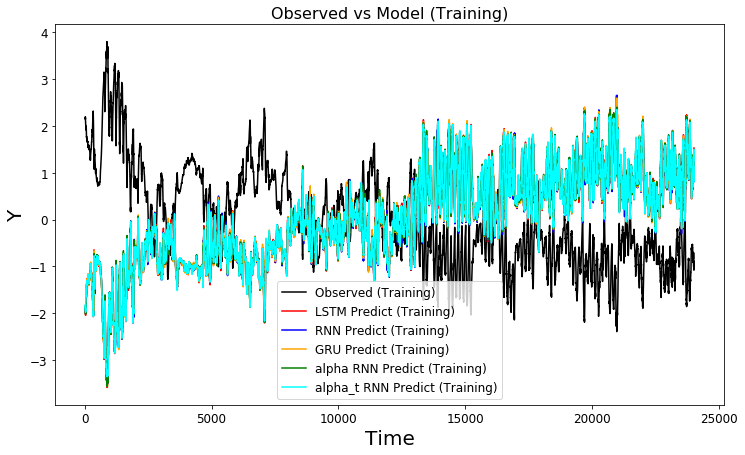

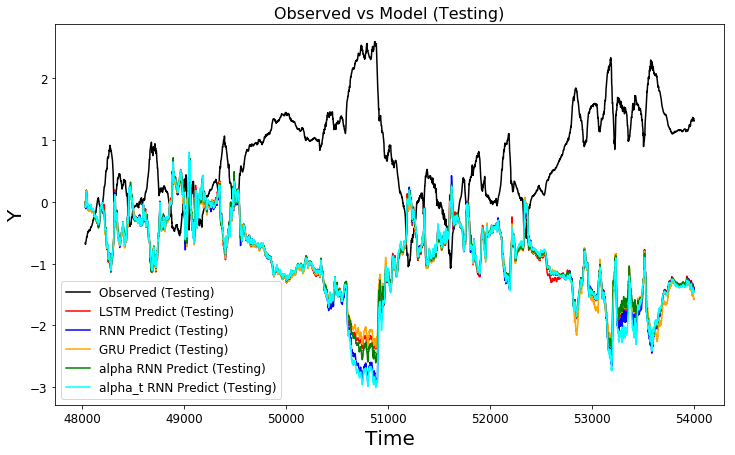

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(std_df_train.index[n_steps+n_steps_ahead-1:], std_df_train[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed (Training)")
train_line_pred = plt.plot(std_df_train.index[n_steps+n_steps_ahead-1:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(std_df_train.index[n_steps+n_steps_ahead-1:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(std_df_train.index[n_steps+n_steps_ahead-1:], gru_pred_train[:, 0], color="orange", label="GRU Predict (Training)")
train_line_pred = plt.plot(std_df_train.index[n_steps+n_steps_ahead-1:], alpharnn_pred_train[:,0], color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(std_df_train.index[n_steps+n_steps_ahead-1:], alpharnnt_pred_train[:,0], color="cyan", label="alpha_t RNN Predict (Training)" )

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], std_df_test[use_feature][n_steps+n_steps_ahead-1:], color="black", label="Observed (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], lstm_pred_test[:, 0], color="red", label="LSTM Predict (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], gru_pred_test[:, 0], color="orange", label="GRU Predict (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], alpharnn_pred_test,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(std_df_test.index[n_steps+n_steps_ahead-1:], alpharnnt_pred_test, color="cyan", label= "alpha_t RNN Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

## Training

In [0]:
    
#%% (3) Initialize and train the model.

# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reserved for the second term
input_dimensions = 1

# Arbitrary number for the size of the hidden state
hidden_size = 10 #<= MFD: vary this between 1,2,5,10,20


In [0]:
#l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
#regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

#regularized_loss = total_loss + regularization_penalty

In [0]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses=[]
batch_size  = 100
max_epochs = 2000
input_dimensions=1
for hidden_size in hidden_sizes:
 val_loss =0
 for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn_t = alphaRNN(input_dimensions, hidden_size)
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss_=train(session, alpharnn_t, x_train, x_test, y_train, y_test, max_epochs=2000, batch_size =int(batch_size/n_splits))
  val_loss+=val_loss_
 val_losses.append(val_loss)

In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
print(hidden_sizes[idx])

In [0]:
session = tf.Session()
alpharnn_t = alphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_train_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:

se = mean_squared_error(y_test_reg[:,0],y_predicted_ar_t)
print(mse)
mse_std = np.math.sqrt(mse)
print(mse_std)

In [0]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses2=[]
batch_size  = int(100/n_splits)
max_epochs = 2000
input_dimensions=1
for hidden_size in hidden_sizes:
 val_loss =0
 for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss_=train(session, alpharnn, x_train, x_test, y_train, y_test, max_epochs, batch_size)
  val_loss+=val_loss_
 val_losses2.append(val_loss)

In [0]:
# AlphaRNN: Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses2))
print(hidden_sizes[idx])

In [0]:
session = tf.Session()
alpharnn = SimpleAlphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

In [0]:
y_predicted = session.run(model.output, feed_dict={model.input_layer: x_train_reg})
y_predicted_train=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_train[i]=y_predicted[i][n_steps-1][0]

In [0]:
#session = tf.Session()
# Add an additional layer on top of each of the hidden state outputs
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
#W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
#b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

#output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 


#model,_=train(alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg)


In [0]:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
#y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
#     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

       

In [0]:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
#y_predicted_ar_train=np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
#     y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]

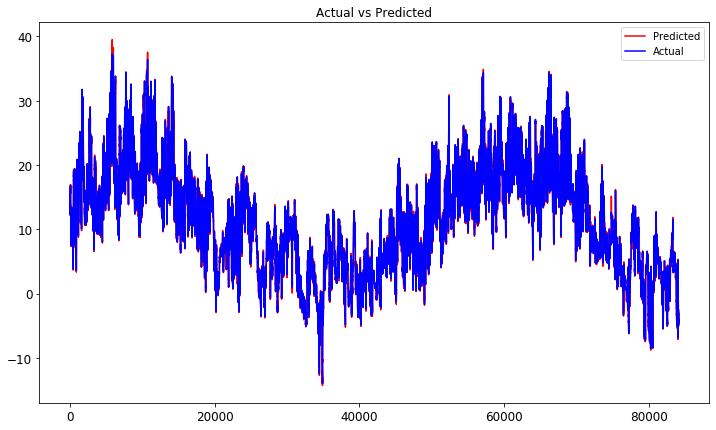

In [0]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()


## Cross-Validation

In [0]:
# Create a new instance of the alpha_RNN model
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)

alpharnn_cv = alphaRNN(input_dimensions, hidden_size)

In [0]:
# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) #prediction

In [0]:
def cross_validate(session, split_size):

  results = []

  tscv = TimeSeriesSplit(split_size)
    
  """
  The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) 
  in the i``th split, with a test set of size ``n_samples//(n_splits + 1), 
  where n_samples is the number of samples.
  
  """

  for train_idx, val_idx in tscv.split(x_train_reg):
    print("TRAIN:", train_idx.shape, "TEST:", val_idx.shape)
    expected_output_val = tf.placeholder(dtype=tf.float64, shape=(len(val_idx), time_size,1), name='expected_output_val')

    train_x = x_train_reg[train_idx]
    train_y = y_train_reg[train_idx]

    val_x = x_train_reg[val_idx]
    val_y = y_train_reg[val_idx]
    
    train(alpharnn, train_x, val_x, train_y, val_y)
    val_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(len(val_idx))
  
    # MFD: suggest to change to val_loss and not use train_loss
    results.append(session.run(val_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y}))

  return results


In [0]:
with tf.Session() as session:
  #saved_path = saver.save(session, './saved_variable')
  #result = cross_validate(session, 5)
  #print('Cross-validation result: %s' % result)
  print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn.input_layer: x_test_reg, expected_output_test: y_test_reg}))

NameError: ignored

In [0]:
session = tf.Session()
# Add an additional layer on top of each of the hidden state outputs
alpharnn_t = alphaRNN(input_dimensions, hidden_size)
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))

output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn_t.h_t) 

train(alpharnn_t, x_train_reg, x_test_reg, y_train_reg, y_test_reg)


Epoch  0 / 200 :  	Training Loss: 21.43568 	Validation Loss: 37.10702
Epoch  50 / 200 :  	Training Loss: 3.98413 	Validation Loss: 4.01063
Epoch  100 / 200 :  	Training Loss: 4.01077 	Validation Loss: 4.08058
Epoch  150 / 200 :  	Training Loss: 3.95643 	Validation Loss: 3.97600


KeyboardInterrupt: ignored

In [0]:
#train_loss = 0
#expected_output_test = 0
with tf.Session() as session:
  #saved_path = saver.save(session, './saved_variable')
  result = cross_validate(session, 5)
  print('Cross-validation result: %s' % result)
  print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn_t.input_layer: x_test_reg, expected_output_test: y_test_reg}))

In [0]:
y_predicted_t = session.run(output, feed_dict={alpharnn_t.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]


In [0]:
y_predicted_t = session.run(output, feed_dict={alpharnn_t.input_layer: x_train_reg})
y_predicted_ar_train_t=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_train_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:
print(train_losses[0][1])

## Diagnostics (visualize fitted values)

In [0]:

# MFD: It would be good to visualize the amount of smoothing, but I get an error
#alpha=session.run(alpharnn.alpha, feed_dict={alpharnn.input_layer: x_test_reg})

In [0]:
#plt.plot(alpha_t[:,n_steps-1,1], 'red')
#pplt.plot(y_test_reg.flatten(),'blue')

# Comparsion with Keras GRU, RNN, LSTM

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001)
 
 

MFD: batch size must match that used for alpha_RNN when comparing LSTM



In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model


In [0]:
n_units = [1,2,5,10,20,50]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=30000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params_['l1_reg']


Hyper parameter tuning for RNN...


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
hidden_size = nodes
rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=500, callbacks=[es])

In [0]:
# predict out of sample
hidden_size = nodes # optimal number of nodes
rnn_model = RNN_model2(hidden_size,l1_reg)
rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()

In [0]:
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for  GRU...")
model = KerasRegressor(build_fn=GRU_model2, epochs=2000, batch_size=30000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_gru = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params_['l1_reg']

In [0]:
hidden_size_gru = nodes_gru
gru_model = Sequential()
gru_model.add(GRU(hidden_size_gru, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')

rnn_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=500, callbacks=[es])

In [0]:
gru_model = GRU_model2(hidden_size_gru,l1_reg)
gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()

In [0]:
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for LSTM...")
model = KerasRegressor(build_fn=LSTM_model2, epochs=2000, batch_size=30000, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes_lstm = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params_['l1_reg']

In [0]:
hidden_size_lstm = nodes_lstm
lstm_model = Sequential()
lstm_model.add(LSTM(hidden_size_lstm, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.fit(x_train_reg, y_train_reg, epochs=2000, batch_size=30000, callbacks=[es])

In [0]:
# predict ouf of sample
lstm_model = LSTM_model2(hidden_size,l1_reg)
lstm_fit = lstm_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()


In [0]:
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)

#print("Hyper parameter tuning for GRU...")        
#model = KerasRegressor(build_fn=GRU_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result2 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
#means = grid_result2.cv_results_['mean_test_score']
#stds = grid_result2.cv_results_['std_test_score']
#params = grid_result2.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))
        
#print("Hyper parameter tuning for LSTM...")
#model = KerasRegressor(build_fn=LSTM_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result3 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
#means = grid_result3.cv_results_['mean_test_score']
#stds = grid_result3.cv_results_['std_test_score']
#params = grid_result3.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))       
                
#nodes = 10# grid_result.best_params_['n_units']
#epochs_rnn = grid_result.best_params_['epochs']
#l1_reg = grid_result.best_params_['l1_reg']
#batch_size_rnn = grid_result.best_params_['batch_size']

#nodes_gru = grid_result2.best_params_['nodes']
#epochs_gru = grid_result2.best_params_['epochs']
#l1_reg_gru = grid_result2.best_params_['l1_reg']
#batch_size_gru = grid_result2.best_params_['batch_size']

#nodes_lstm = grid_result3.best_params_['nodes']
#epochs_lstm = grid_result3.best_params_['epochs']
#l1_reg_lstm = grid_result3.best_params_['l1_reg']
#batch_size_lstm = grid_result3.best_params_['batch_size']
#print("Hyper parameter tuning for RNN...")
#model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV

#nodes = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]
#l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#n_splits = 10
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
#MSE_train = 0
#MSE_test = 0
#TimeSeriesSplit(max_train_size=None, n_splits=10)
#tscv = TimeSeriesSplit()
#for train_fold, test_fold in tscv.split(x_train_reg):
#    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
#    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
#    rnn_model = RNN_model2(nodes,l1_reg)
   
#    rnn_fit = rnn_model.fit(x_train,y_train, epochs=500, batch_size=100, callbacks=[es])
#    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
#    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
#    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
#    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
#rnn_model.summary()
#MSE_train_ave = MSE_train/n_splits
#MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
#MSE_test_ave = MSE_test/n_splits
#MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
#print("MSE_train_rnn_ave = " + str(MSE_train_ave))
#print("MSE_test_rnn_ave = " + str(MSE_test_ave))
#print("MSE_train_rnn_std = " + str(MSE_train_std))
#print("MSE_test_rnn_std = " + str(MSE_test_std))
#print("p = " + str(p))

#rnn_model = RNN_model2(nodes,l1_reg)
#rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
#rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
#mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
#print("RNN test data mse = " + str(mse))
#print("RNN test std mse = " + str(np.sqrt(mse)))
#rnn_model.summary()



#lstm_model = Sequential()
#lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
#lstm_model.add(Dense(1))
#lstm_model.compile(loss='mean_squared_error', optimizer='adam')

#lstm_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=100, callbacks=[es])

Epoch 1/500
56075/56075 [==============================] - 2s 27us/step - loss: 3.0704
Epoch 2/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.1056
Epoch 3/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0871
Epoch 4/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0736
Epoch 5/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0649
Epoch 6/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0593
Epoch 7/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0532
Epoch 8/500
56075/56075 [==============================] - 1s 17us/step - loss: 0.0503
Epoch 9/500
56075/56075 [==============================] - 1s 17us/step - loss: 0.0468
Epoch 10/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0461
Epoch 11/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0449
Epoch 12/500
56075/56075 [===============

In [0]:
# Need to cross-validate for the best number of hidden units (i.e. hidden_size)

#print("Hyper parameter tuning for GRU...")        
#model = KerasRegressor(build_fn=GRU_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result2 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
#means = grid_result2.cv_results_['mean_test_score']
#stds = grid_result2.cv_results_['std_test_score']
#params = grid_result2.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#       print("%f (%f) with %r" % (mean, stdev, param))
        
#print("Hyper parameter tuning for LSTM...")
#model = KerasRegressor(build_fn=LSTM_model2, epochs=1500, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result3 = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
#means = grid_result3.cv_results_['mean_test_score']
#stds = grid_result3.cv_results_['std_test_score']
#params = grid_result3.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))       
                
#nodes = 10# grid_result.best_params_['n_units']
#epochs_rnn = grid_result.best_params_['epochs']
#l1_reg = grid_result.best_params_['l1_reg']
#batch_size_rnn = grid_result.best_params_['batch_size']

#nodes_gru = grid_result2.best_params_['nodes']
#epochs_gru = grid_result2.best_params_['epochs']
#l1_reg_gru = grid_result2.best_params_['l1_reg']
#batch_size_gru = grid_result2.best_params_['batch_size']

#nodes_lstm = grid_result3.best_params_['nodes']
#epochs_lstm = grid_result3.best_params_['epochs']
#l1_reg_lstm = grid_result3.best_params_['l1_reg']
#batch_size_lstm = grid_result3.best_params_['batch_size']
#print("Hyper parameter tuning for RNN...")
#model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=1)
#grid = GridSearchCV(estimator=model,param_grid=param_grid, n_jobs=-1, cv=10)
#grid_result = grid.fit(X_train,y_train,callbacks=[es])
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV

#nodes = grid_result.best_params_['n_units']
#l1_reg = grid_result.best_params['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]
#l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#n_splits = 10
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
#MSE_train = 0
#MSE_test = 0
#TimeSeriesSplit(max_train_size=None, n_splits=10)
#tscv = TimeSeriesSplit()
#for train_fold, test_fold in tscv.split(x_train_reg):
#    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
#    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
#    rnn_model = RNN_model2(nodes,l1_reg)
   
#    rnn_fit = rnn_model.fit(x_train,y_train, epochs=500, batch_size=100, callbacks=[es])
#    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
#    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
#    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
#    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
#rnn_model.summary()
#MSE_train_ave = MSE_train/n_splits
#MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
#MSE_test_ave = MSE_test/n_splits
#MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
#print("MSE_train_rnn_ave = " + str(MSE_train_ave))
#print("MSE_test_rnn_ave = " + str(MSE_test_ave))
#print("MSE_train_rnn_std = " + str(MSE_train_std))
#print("MSE_test_rnn_std = " + str(MSE_test_std))
#print("p = " + str(p))

#rnn_model = RNN_model2(nodes,l1_reg)
#rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
#rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
#mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
#print("RNN test data mse = " + str(mse))
#print("RNN test std mse = " + str(np.sqrt(mse)))
#rnn_model.summary()



#lstm_model = Sequential()
#lstm_model.add(LSTM(hidden_size, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
#lstm_model.add(Dense(1))
#lstm_model.compile(loss='mean_squared_error', optimizer='adam')

#lstm_model.fit(x_train_reg, y_train_reg, epochs=1500, batch_size=100, callbacks=[es])

Epoch 1/500
56075/56075 [==============================] - 2s 27us/step - loss: 3.0704
Epoch 2/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.1056
Epoch 3/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0871
Epoch 4/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0736
Epoch 5/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0649
Epoch 6/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0593
Epoch 7/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0532
Epoch 8/500
56075/56075 [==============================] - 1s 17us/step - loss: 0.0503
Epoch 9/500
56075/56075 [==============================] - 1s 17us/step - loss: 0.0468
Epoch 10/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0461
Epoch 11/500
56075/56075 [==============================] - 1s 18us/step - loss: 0.0449
Epoch 12/500
56075/56075 [===============

### LSTM


### RNN

### GRU

### Prediction

In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

84101/84101 [==============================] - 3s 40us/step


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

84101/84101 [==============================] - 2s 26us/step


In [0]:
# compare with the trained plain GRU

In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

84101/84101 [==============================] - 3s 39us/step


### Model Performance

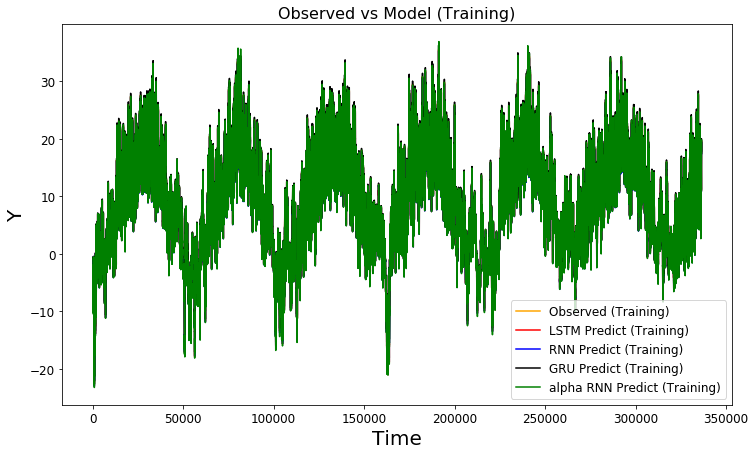

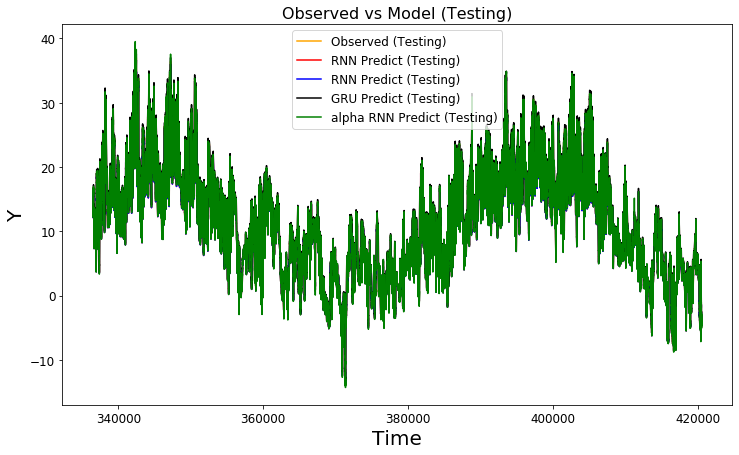

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="orange", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="black", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_train, color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_train_t, color="yellow", label="alpha_t RNN Predict (Training)")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)


fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="orange", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="red", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="black", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:],y_predicted_ar,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:],y_predicted_ar_t, color="yellow",label="alpha_t RNN Predict (Testing)"
test_line_pred = plt.plot(y_predicted_ar_t, color="yellow", label="alpha_t RNN Predict (Testing)")

# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

In [0]:
# calculate mean squared error of the plain LSTM
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], lstm_pred_test[:, 0])
print(MSE_test)

NameError: ignored

In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:],y_prediction_train) # train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_prediction_ar) # validation_losses[:, 0])
print(MSE_test)

In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps:],y_prediction_train) # train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_prediction_ar) # validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)

In [0]:
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], y_predicted_train_t)  #train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], y_predicted_ar_t)     #validation_losses[:, 0])
print(MSE_test)
MSE_train_sd = np.sqrt(MSE_train)
print(MSE_train_sd)
MSE_test_sd = np.sqrt(MSE_test)
print(MSE_test_sd)